In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [127]:
# Import libraries
import logging
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import shap
import joblib
import lime
from lime import lime_tabular
from lime import submodular_pick
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV,GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, classification_report, cohen_kappa_score, precision_score, recall_score, balanced_accuracy_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import optuna
from optuna.visualization.matplotlib import plot_optimization_history


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Supporting Functions

In [3]:
 # Function to assess Model performance
def conf_matrix_classif_report(model, y_test, y_pred_val):
  """
  model : str variable with model name to be used for titles.
  y_test : Variable with True label list
  y_pred_val : Variable with Model predicted values.
  """

  # Target classes
  class_label = ['3','4','5']

  # Model primary metric: f1 macro score
  model_f1_macro_score= f1_score(y_test, y_pred_val, average='macro')
  print('')
  print(f"{model} f1 macro score: {model_f1_macro_score}")

  # Model support metric: precision macro score
  model_precision_macro_score = precision_score(y_test, y_pred_val, average='macro')
  print('')
  print(f"{model} precision macro score: {model_precision_macro_score}")

  # Model support metric: recall macro score
  model_recall_macro_score = recall_score(y_test, y_pred_val, average='macro')
  print('')
  print(f"{model} recall macro score: {model_recall_macro_score}")

   # Model support metric: balanced accuracy score
  model_balanced_accuracy_score= balanced_accuracy_score(y_test, y_pred_val)
  print('')
  print(f"{model} balanced accuracy score: {model_balanced_accuracy_score}")

   # Model support metric: accuracy score
  model_accuracy_score= accuracy_score(y_test, y_pred_val)
  print('')
  print(f"{model} accuracy score: {model_accuracy_score}")

  # Model support metric: cohen kappa score
  model_cohen_kappa_score= cohen_kappa_score(y_test, y_pred_val)
  print('')
  print(f"{model} cohen kappa score: {model_cohen_kappa_score}")

  # Classification report
  classif_report = classification_report(y_test, y_pred_val)
  print('')
  print(f"Classification Report:\n\n{classif_report}")
  print('')
  
  # Confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred_val)
  sns.set(font_scale=1.2) 
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  tick_pos = np.arange(len(class_label)) + 0.5
  plt.xticks(tick_pos, class_label)
  plt.yticks(tick_pos, class_label)
  plt.title(f"Confusion Matrix: {model}")
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()

In [39]:
# ROC AUC Score function
def roc_curves(model,y_train, y_test, y_pred):
    # Reshape target label
    y_train_reshaped_ohe = y_train.reshape(-1, 1)
    y_test_reshaped_ohe = y_test.reshape(-1, 1)
    y_pred_reshaped_ohe = y_pred.reshape(-1, 1)

    # OneHotEncode reshaped target label 
    ohe  = OneHotEncoder(sparse=False, handle_unknown='ignore')
    y_train_ohe = ohe.fit_transform(y_train_reshaped_ohe)
    y_test_ohe = ohe.transform(y_test_reshaped_ohe)
    y_pred_ohe = ohe.transform(y_pred_reshaped_ohe)

    # Compute ROC cuver and calculate AUC score 
    for i in range(y_train_ohe.shape[1]):
      fpr, tpr, _ = roc_curve(y_test_ohe[:,i], y_pred_ohe[:,i]) # Compute ROC curve for the current class
      auc_score = roc_auc_score(y_test_ohe[:,i], y_pred_ohe[:,i]) # Calculate AUC score for the ROC curve
      # Plot ROC curve and class label together with AUC
      plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='-',color='black')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model} - ROC Curves")
    plt.legend(loc='lower right')
    plt.show()

## Load Data

In [3]:
# Load file paths
full_dataset = "add_path"

In [4]:
# Load datasets
bike_full_df = pd.read_csv(full_dataset, header = 0, sep = ';')
print(bike_full_df.shape)

(2035394, 43)


Selecting relevant Age Groups

In [5]:
# Removing Unknown ageRange: 0  from dataset
bike_full_df = bike_full_df[bike_full_df['ageRange'].isin([3,4,5])]

print(bike_full_df.shape)
print(bike_full_df.dtypes)

(1991440, 43)
_id                           object
user_day_code                 object
idplug_base                    int64
user_type                      int64
idunplug_base                  int64
travel_time                    int64
idunplug_station               int64
ageRange                       int64
idplug_station                 int64
unplug_hourTime               object
zip_code                      object
temp_unplug_hourTime          object
year                           int64
month                          int64
day                            int64
hour                           int64
travel_time_min              float64
travel_revenue               float64
id_weather                     int64
80                           float64
81                           float64
82                           float64
83                           float64
86                           float64
87                           float64
88                           float64
89                      

In [7]:
bike_full_df['ageRange'].unique()

array([5, 3, 4], dtype=int64)

In [6]:
# Remove outliers
bike_full_df = bike_full_df[bike_full_df['travel_time_min']<=30]
bike_full_df.shape

(1905493, 43)

## Feature Selection

In [9]:
bike_full_df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['_id', 'user_day_code', 'idplug_base', 'user_type', 'idunplug_base',
       'travel_time', 'idunplug_station', 'ageRange', 'idplug_station',
       'unplug_hourTime', 'zip_code', 'temp_unplug_hourTime', 'year', 'month',
       'day', 'hour', 'travel_time_min', 'travel_revenue', 'id_weather', '80',
       '81', '82', '83', '86', '87', '88', '89', 'date', 'week_day',
       'WorkingDay_Holiday_Sunday', 'holiday_type', 'holiday_desc',
       'day_of_week', 'unplug_station_tot_bases', 'idunplug_latitude',
       'idunplug_longitude', 'plug_station_tot_bases', 'idplug_latitude',
       'idplug_longitude', 'mh_distance_meters', 'time_group',
       'unique_user_day_code', 'tot_trips_day'],
      dtype='object')>

In [7]:
# Feature selection
bike_full_df.columns.to_list
selected_columns = [
    #'idplug_base', 
    #'idunplug_base',
    'travel_time', 
    #'idunplug_station', # Replaced with idunplug_latitude / longitude
    'idunplug_latitude',
    'idunplug_longitude',
    'unplug_station_tot_bases',
    'ageRange', 
    #'idplug_station', # Replaced with iduplug_latitude / longitude
    'idplug_latitude',
    'idplug_longitude',
    'plug_station_tot_bases',
    #'unplug_hourTime', 
    #'zip_code',
    #'year', 
    'month',
    'day', 
    'hour',
    'time_group', 
    'travel_revenue',
    'tot_trips_day',
    'mh_distance_meters', 
    #'80', # Contains NaN Values
    '81', 
    '82', 
    '83', 
    '86', 
    '87', 
    '88', 
    '89',
    'day_of_week',
    #'WorkingDay_Holiday_Sunday', 
    'holiday_type' 
    #'holiday_desc',
       ]


filter_bike_df = bike_full_df[selected_columns]
print(filter_bike_df.dtypes)
display(filter_bike_df.head())

print(f"Present NA values: {filter_bike_df.isna().sum()}")

travel_time                   int64
idunplug_latitude           float64
idunplug_longitude          float64
unplug_station_tot_bases      int64
ageRange                      int64
idplug_latitude             float64
idplug_longitude            float64
plug_station_tot_bases        int64
month                         int64
day                           int64
hour                          int64
time_group                    int64
travel_revenue              float64
tot_trips_day                 int64
mh_distance_meters          float64
81                          float64
82                          float64
83                          float64
86                          float64
87                          float64
88                          float64
89                          float64
day_of_week                   int64
holiday_type                 object
dtype: object


,travel_time,idunplug_latitude,idunplug_longitude,unplug_station_tot_bases,ageRange,idplug_latitude,idplug_longitude,plug_station_tot_bases,month,day,hour,time_group,travel_revenue,tot_trips_day,mh_distance_meters,81,82,83,86,87,88,89,day_of_week,holiday_type
0,415,40.403408,-3.710811,24,5,40.415010,-3.706103,18,1,1,0,0,0.5,1,1760.389172,0.69,22.0,4.4,67.0,957.0,101.0,0.0,1,national_holiday
1,417,40.424846,-3.673863,24,3,40.444226,-3.678717,18,1,1,0,0,0.5,1,2641.794256,0.69,22.0,4.4,67.0,957.0,101.0,0.0,1,national_holiday
2,448,40.404785,-3.702827,24,4,40.413885,-3.704941,24,1,1,0,0,0.5,1,1221.373443,0.69,22.0,4.4,67.0,957.0,101.0,0.0,1,national_holiday
3,468,40.422658,-3.687055,24,5,40.429887,-3.671282,24,1,1,0,0,0.5,1,2405.058377,0.69,22.0,4.4,67.0,957.0,101.0,0.0,1,national_holiday
4,149,40.417924,-3.670896,24,4,40.421398,-3.675204,24,1,1,0,0,0.5,1,821.854857,0.69,22.0,4.4,67.0,957.0,101.0,0.0,1,national_holiday


Present NA values: travel_time                 0
idunplug_latitude           0
idunplug_longitude          0
unplug_station_tot_bases    0
ageRange                    0
idplug_latitude             0
idplug_longitude            0
plug_station_tot_bases      0
month                       0
day                         0
hour                        0
time_group                  0
travel_revenue              0
tot_trips_day               0
mh_distance_meters          0
81                          0
82                          0
83                          0
86                          0
87                          0
88                          0
89                          0
day_of_week                 0
holiday_type                0
dtype: int64


## Train, test split

In [8]:
# Set up random state for reproducible results
rand_state = 123

# Set up number of folds for cross validation:
numb_split = 5

In [9]:
# Train, test split stratify based on ageRange
train, test = train_test_split(filter_bike_df, stratify=filter_bike_df["ageRange"],test_size=0.20, random_state=123)

In [10]:
# Splitting target vs independent variables
X_train = train.drop("ageRange", axis=1)
y_train = train["ageRange"].values

X_test = test.drop("ageRange", axis=1)
y_test = test["ageRange"].values

In [11]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train length: {len(y_train)}")
print("")
print(f"X_test shape: {X_test.shape}")
print(f"y_test length: {len(y_test)}")

X_train shape: (1524394, 23)
y_train length: 1524394

X_test shape: (381099, 23)
y_test length: 381099


### Common Preprocessing steps:


In [12]:
# Common Preprocessing steps:
featurizer = ColumnTransformer(
    transformers=[
        ('one_hot_en',OneHotEncoder(sparse=False, handle_unknown='ignore'),['holiday_type'
                                                                            ]),
        ('normalization',MinMaxScaler(),['travel_time',
                                         'idunplug_latitude',
                                         'idunplug_longitude',
                                         'unplug_station_tot_bases',
                                         'idplug_latitude',
                                         'idplug_longitude',
                                         'plug_station_tot_bases',
                                         'tot_trips_day',
                                         'travel_revenue',
                                         'mh_distance_meters',
                                         '81',
                                         '82',
                                         '83',
                                         '86',
                                         '87',
                                         '88',
                                         '89'
                                            ]
                                            )                                        
                ],
                                                remainder='passthrough')

In [13]:
# Fit and transform X_train set
X_train_trans_rfc = featurizer.fit_transform(X_train)
display(X_train_trans_rfc)

# Transform X_test set
X_test_trans_rfc = featurizer.transform(X_test)


array([[ 0.,  0.,  0., ...,  6.,  0.,  1.],
       [ 0.,  0.,  0., ..., 10.,  2.,  4.],
       [ 0.,  0.,  0., ..., 19.,  3.,  6.],
       ...,
       [ 0.,  0.,  0., ..., 18.,  3.,  5.],
       [ 0.,  0.,  0., ...,  8.,  1.,  0.],
       [ 0.,  0.,  0., ..., 13.,  2.,  6.]])

In [14]:
display(X_train.iloc[0])
display(X_train_trans_rfc[0])

travel_time                         976
idunplug_latitude             40.435285
idunplug_longitude            -3.694863
unplug_station_tot_bases             24
idplug_latitude               40.421862
idplug_longitude              -3.695498
plug_station_tot_bases               24
month                                 9
day                                   3
hour                                  6
time_group                            0
travel_revenue                      0.5
tot_trips_day                         2
mh_distance_meters          1551.409508
81                                 1.38
82                                  1.0
83                                 25.5
86                                 39.0
87                                946.0
88                                257.0
89                                  0.0
day_of_week                           1
holiday_type                 workingday
Name: 1329746, dtype: object

array([0.        , 0.        , 0.        , 0.        , 1.        ,
       0.54196776, 0.5850373 , 0.43096397, 0.66666667, 0.40579311,
       0.42176765, 0.66666667, 0.05263158, 0.25      , 0.15410796,
       0.15849057, 0.        , 0.86879433, 0.21052632, 0.64864865,
       0.68548387, 0.        , 9.        , 3.        , 6.        ,
       0.        , 1.        ])

In [18]:
# SHAP Feature Importance col_names
model_feature_names = ['holiday_type_local_holiday_in_the_city_of_madrid',
 'holiday_type_madrid_community_public_holiday',
 'holiday_type_national_holiday',
 'holiday_type_weekend',
 'holiday_type_workingday',
 'travel_time',
 'idunplug_latitude',
 'idunplug_longitude',
 'unplug_station_tot_bases',
 'idplug_latitude',
 'idplug_longitude',
 'plug_station_tot_bases',
 'tot_trips_day',
 'travel_revenue',
 'mh_distance_meters',
 '81',
 '82',
 '83',
 '86',
 '87',
 '88',
 '89',
 'month',
 'day',
 'hour',
 'time_group',
 'day_of_week']

## Baseline RandomForestClassifier

### Baseline Random Forest Classifier

In [25]:
# Baseline Random Forest (Values not linked to Baseline but tests on RandomSearch Result)
rand_state = 123

# Create RandomForestClassifier model
base_rfc = RandomForestClassifier(random_state=rand_state, n_jobs=-1, n_estimators=450, max_features='sqrt', max_depth=42)

# Fit model with entire training set
base_rfc.fit(X_train_trans_rfc,y_train)

# Make predictions on the test set
base_rfc_pred = base_rfc.predict(X_test_trans_rfc)

# Evaluate model
base_rfc_pred_f1_score = f1_score(y_test, base_rfc_pred, average=None)
print(f"Base RFC F1 score : {base_rfc_pred_f1_score}")

Base RFC F1 score : [0.39178568 0.77810307 0.65871354]


In [26]:
print(classification_report(y_test, base_rfc_pred))
print(confusion_matrix(y_test, base_rfc_pred))

              precision    recall  f1-score   support

           3       0.84      0.26      0.39     36280
           4       0.69      0.89      0.78    202822
           5       0.75      0.59      0.66    141997

    accuracy                           0.71    381099
   macro avg       0.76      0.58      0.61    381099
weighted avg       0.73      0.71      0.70    381099

[[  9272  21380   5628]
 [  1066 179664  22092]
 [   714  57934  83349]]


In [ ]:
base_rfc_f1_macro_score= f1_score(y_test, base_rfc_pred, average='macro')
base_rfc_f1_macro_score

0.6098071179505121


Base RFC f1 macro score: 0.6095340987360038

Base RFC balanced accuracy score: 0.5761220201295468

Base RFC accuracy score: 0.7144731421494153

Base RFC cohen kappa score: 0.4581889537432915

Classification Report:

              precision    recall  f1-score   support

           3       0.84      0.26      0.39     36280
           4       0.69      0.89      0.78    202822
           5       0.75      0.59      0.66    141997

    accuracy                           0.71    381099
   macro avg       0.76      0.58      0.61    381099
weighted avg       0.73      0.71      0.70    381099




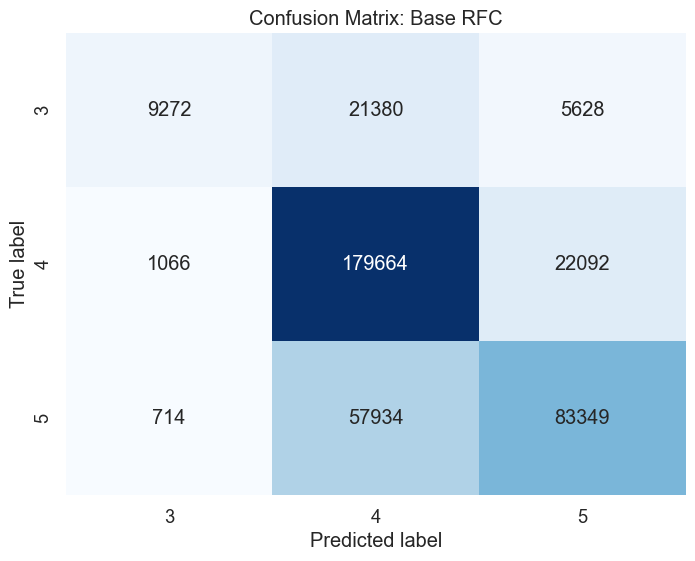

In [27]:
conf_matrix_classif_report('Base RFC',y_test, base_rfc_pred)

In [25]:
# Get the individual decision trees from the random forest
individual_trees = base_rfc.estimators_

# Initialize a list to store the depths of individual trees
tree_depths = []

# Loop through each tree and calculate its depth
for tree in individual_trees:
    depth = tree.tree_.max_depth
    tree_depths.append(depth)

# Get the maximum depth among all trees
min_depth_rf = min(tree_depths)
max_depth_rf = max(tree_depths)

print("Minimum depth of trees in RandomForestClassifier:", min_depth_rf)
print("Maximum depth of trees in RandomForestClassifier:", max_depth_rf)

Minimum depth of trees in RandomForestClassifier: 51
Maximum depth of trees in RandomForestClassifier: 65


## Model optimization RFC GridSearch

In [28]:
# Subset to be able to test hyperparameter tunning
sub_X_train_trans_rfc = X_train_trans_rfc[:100]
sub_y_train = y_train[:100]
sub_X_test_trans_rfc = X_test_trans_rfc[:100]
sub_y_test = y_test[:100]


sub_y_test

array([5, 4, 4, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 4, 4, 5,
       5, 5, 5, 4, 3, 5, 4, 5, 5, 4, 4, 5, 4, 3, 5, 5, 4, 5, 3, 4, 3, 4,
       3, 4, 5, 4, 5, 5, 5, 3, 5, 4, 4, 4, 4, 5, 5, 5, 4, 5, 5, 5, 5, 4,
       4, 5, 4, 5, 4, 3, 4, 5, 4, 4, 4, 5, 4, 3, 4, 4, 4, 4, 5, 3, 3, 4,
       4, 4, 5, 5, 5, 4, 5, 5, 4, 4, 5, 5], dtype=int64)

In [ ]:
numb_split = 5
rand_state = 123

# Define the hyperparameters and their possible values 
param_grid_rfc = {'n_estimators': [100, 300, 450], # Based on Optuna Random Search Results.
              'max_features': ['sqrt', 'log2'], 
              'max_depth': [34,52]} # Based on Optuna Random Search Results.

# Define the scoring metric as F1 score macro
scoring = make_scorer(f1_score, average='macro')

# Start measuring time
start_time = time.time()
rfc = RandomForestClassifier(random_state=rand_state, n_jobs=-1)

# Create StratifiedKFold object for stratified cross-validation
skf = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state )

# Create a grid search object
grid_search_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc, scoring=scoring, cv=skf)

# Fit the grid search to your data
grid_search_rfc.fit(X_train_trans_rfc, y_train)

# Calculate elapsed time
end_time = time.time()
elapsed_time_rfc = end_time - start_time

# Print the best hyperparameters
print(f"Elapsed time: {elapsed_time_rfc} seconds")
print("Best Hyperparameters:", grid_search_rfc.best_params_)
print("Best performance:", grid_search_rfc.best_score_)

In [18]:
std_rfc_best_score = grid_search_rfc.cv_results_['std_test_score'][grid_search_rfc.best_index_]

print(f"RFC GridSearch Beast std mean f1 macro performance: {std_rfc_best_score}")

RFC GridSearch Beast std mean f1 macro performance: 0.0006544906525010089


In [19]:
def plot_tuning_results_rfc(df_val):
    
    df_sqrt = df_val[:][df_val.max_features == 'sqrt'].sort_values(by=['n_estimators', 'max_depth'])
    df_log2 = df_val[:][df_val.max_features == 'log2'].sort_values(by=['n_estimators', 'max_depth'])

    pivot1 = df_sqrt.pivot_table(index='max_depth',columns='n_estimators',values='mean_f1_macro')
    pivot2 = df_log2.pivot_table(index='max_depth',columns='n_estimators',values='mean_f1_macro')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    sns.heatmap(pivot1,vmin=0.15,vmax=0.65,annot=True,linewidths=0.4,ax=ax1,cmap="coolwarm_r")
    sns.heatmap(pivot2,vmin=0.15,vmax=0.65,annot=True,linewidths=0.4,ax=ax2,cmap="coolwarm_r")
    
    ax1.set_title("max_features: sqrt")
    ax2.set_title("max_features: log2")

In [20]:
df_grid_rfc = pd.DataFrame(grid_search_rfc.cv_results_["params"])
df_grid_rfc
df_grid_rfc['mean_f1_macro'] = np.round(grid_search_rfc.cv_results_["mean_test_score"],3)
df_grid_rfc['std_f1_macro'] = np.round(grid_search_rfc.cv_results_["std_test_score"],3)
df_grid_rfc


,max_depth,max_features,n_estimators,mean_f1_macro,std_f1_macro
0,34,sqrt,100,0.585,0.001
1,34,sqrt,300,0.588,0.001
2,34,sqrt,450,0.588,0.001
3,34,log2,100,0.563,0.001
4,34,log2,300,0.566,0.000
5,34,log2,450,0.567,0.001
6,52,sqrt,100,0.587,0.001
7,52,sqrt,300,0.589,0.001
8,52,sqrt,450,0.590,0.001
9,52,log2,100,0.566,0.001


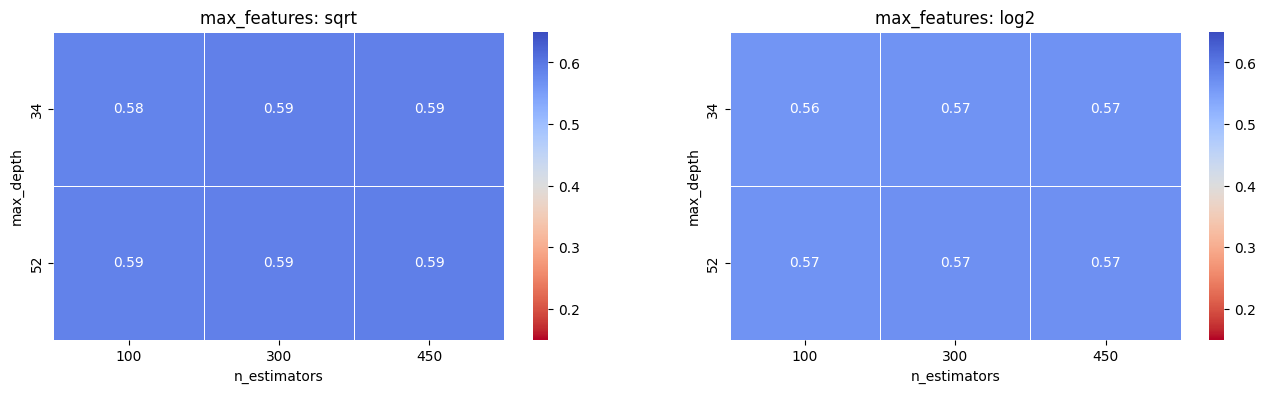

In [21]:
plot_tuning_results_rfc(df_grid_rfc)

In [22]:
# Store best Hyperparameters in a variable
grid_rfc_params = grid_search_rfc.best_params_
print(grid_rfc_params)

{'max_depth': 52, 'max_features': 'sqrt', 'n_estimators': 450}


In [23]:
# Select best hyperparameters for optimized model training
best_grid_params_rfc = dict(n_estimators = grid_rfc_params['n_estimators'], max_features = grid_rfc_params['max_features'], max_depth = grid_rfc_params['max_depth']
                         )

print(f"RF Classifier GridSearch Optimized Hyperparameters: {best_grid_params_rfc}")

RF Classifier GridSearch Optimized Hyperparameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 52}


### Tune RFC model CV:

In [44]:
best_grid_params_rfc = {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 52}

In [19]:
# Evaluate model with cross validation using F1 macro score
f1_scorer = make_scorer(f1_score, average='macro')

# Define Tune RandomForestClassifier model
tune_rfc_cv = RandomForestClassifier(**best_grid_params_rfc, random_state=rand_state, n_jobs=-1)

# Define the StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state)

# Measure traininig time
start_time = time.time()
tune_rfc_cv_results = cross_validate(tune_rfc_cv, X_train_trans_rfc, y_train, cv=stratified_kfold, scoring=f1_scorer, return_train_score=True)
end_time = time.time()
tune_rfc_train_time = end_time - start_time

In [20]:
# Print the cross-validation training time and scores:
print(f"Tune RFC training time: {tune_rfc_train_time} seconds for K-fold: {numb_split}\n")

Tune RFC training time: 3218.7378466129303 seconds for K-fold: 5



In [21]:
# Train performance
print(f"Tune RFC Cross-val Mean f1 macro train_score: {np.mean(tune_rfc_cv_results['train_score'])}")
print(f"Tune RFC Cross-val Standard Deviation of f1 macro train_score: {np.std(tune_rfc_cv_results['train_score'])}\n")

Tune RFC Cross-val Mean f1 macro train_score: 0.9999633530927629
Tune RFC Cross-val Standard Deviation of f1 macro train_score: 2.422176598267929e-06



In [22]:
# Validation performance
print(f"Tune RFC Cross-val Mean f1 macro val_score: {np.mean(tune_rfc_cv_results['test_score'])}")
print(f"Tune RFC Cross-val Standard Deviation of f1 macro val_score: {np.std(tune_rfc_cv_results['test_score'])}")

Tune RFC Cross-val Mean f1 macro val_score: 0.5897511243326677
Tune RFC Cross-val Standard Deviation of f1 macro val_score: 0.0006544906525010089


### Tune RFC Test performance

In [20]:
best_grid_params_rfc = {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 52}
#Grid optimized RF Classifier model: 
tune_rfc = RandomForestClassifier(**best_grid_params_rfc, random_state=rand_state, n_jobs = -1)     

# Fit model with entire training dataset
tune_rfc.fit(X_train_trans_rfc, y_train)

RandomForestClassifier(max_depth=52, n_estimators=450, n_jobs=-1,
                       random_state=123)

In [21]:
# Make predictions on the test dataset
tune_rfc_pred = tune_rfc.predict(X_test_trans_rfc)

tune_rfc_f1_score = f1_score(y_test, tune_rfc_pred, average=None)
print(f"Tune RFC model F1 score: {tune_rfc_f1_score}")

Tune RFC model F1 score: [0.39321905 0.77797626 0.65822605]



Tune Model - RFC f1 macro score: 0.6098071179505121

Tune Model - RFC precision macro score: 0.7612252382479459

Tune Model - RFC recall macro score: 0.5762717170213584

Tune Model - RFC balanced accuracy score: 0.5762717170213584

Tune Model - RFC accuracy score: 0.7143183267339982

Tune Model - RFC cohen kappa score: 0.4579018862154719

Classification Report:

              precision    recall  f1-score   support

           3       0.84      0.26      0.39     36280
           4       0.69      0.89      0.78    202822
           5       0.75      0.59      0.66    141997

    accuracy                           0.71    381099
   macro avg       0.76      0.58      0.61    381099
weighted avg       0.73      0.71      0.70    381099




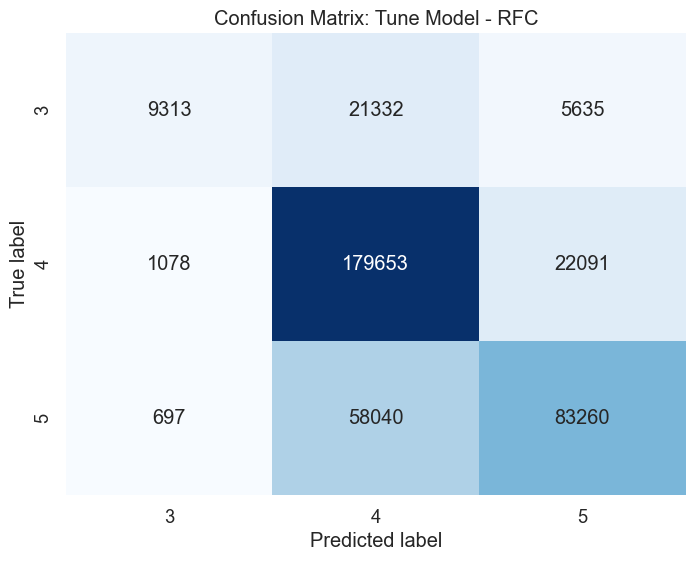

In [47]:
conf_matrix_classif_report('Tune Model - RFC', y_test, tune_rfc_pred)

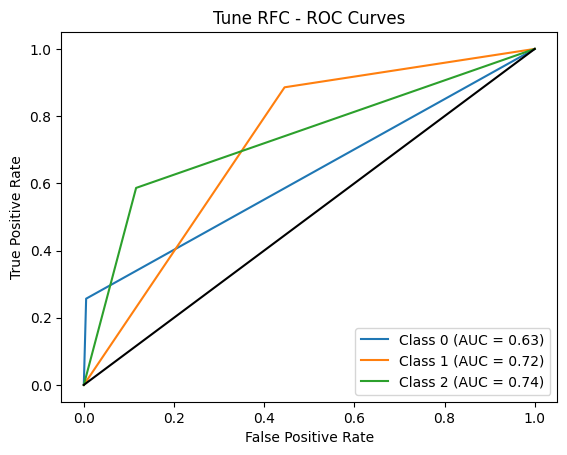

In [18]:
# Test performance
roc_curves("Tune RFC", y_train, y_test, tune_rfc_pred)

### SHAP Feature Importance

In [22]:
model_feature_names = ['holiday_type_local_holiday_in_the_city_of_madrid',
 'holiday_type_madrid_community_public_holiday',
 'holiday_type_national_holiday',
 'holiday_type_weekend',
 'holiday_type_workingday',
 'travel_time',
 'idunplug_latitude',
 'idunplug_longitude',
 'unplug_station_tot_bases',
 'idplug_latitude',
 'idplug_longitude',
 'plug_station_tot_bases',
 'tot_trips_day',
 'travel_revenue',
 'mh_distance_meters',
 '81',
 '82',
 '83',
 '86',
 '87',
 '88',
 '89',
 'month',
 'day',
 'hour',
 'time_group',
 'day_of_week']

In [23]:
X_test_trans_rfc[5]


array([ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.34741523,  0.62838952,  0.38238132,  0.66666667,  0.81780077,
        0.37099912,  0.66666667,  0.10526316,  0.25      ,  0.16405174,
        0.84716981,  0.60055866,  0.29787234,  0.90789474,  0.21621622,
        0.20967742,  0.03571429,  1.        , 31.        , 13.        ,
        2.        ,  3.        ])

In [24]:
# Select stratified sample size
sub_X_train_bad, sub_X_test, sub_y_train_bad, sub_y_test = train_test_split(X_test_trans_rfc, y_test, test_size = 0.0008, stratify=y_test, random_state = rand_state)

In [25]:
# Summarize data using k-means due to computational limitations
summary_test_background = shap.kmeans(sub_X_test, 3)

# Create an explainer using SHAP Kernel with summarize sub_test data
kernel_explainer = shap.KernelExplainer(tune_rfc.predict,summary_test_background)

# Compute SHAP valuse for the test data:
shap_val_test_kernel = kernel_explainer.shap_values(sub_X_test)

100%|██████████| 305/305 [02:38<00:00,  1.92it/s]


In [26]:
# Display random selected samples:
y_shap_sub_test = pd.DataFrame(sub_y_test)
y_shap_sub_test.value_counts()

0
4    162
5    114
3     29
Name: count, dtype: int64

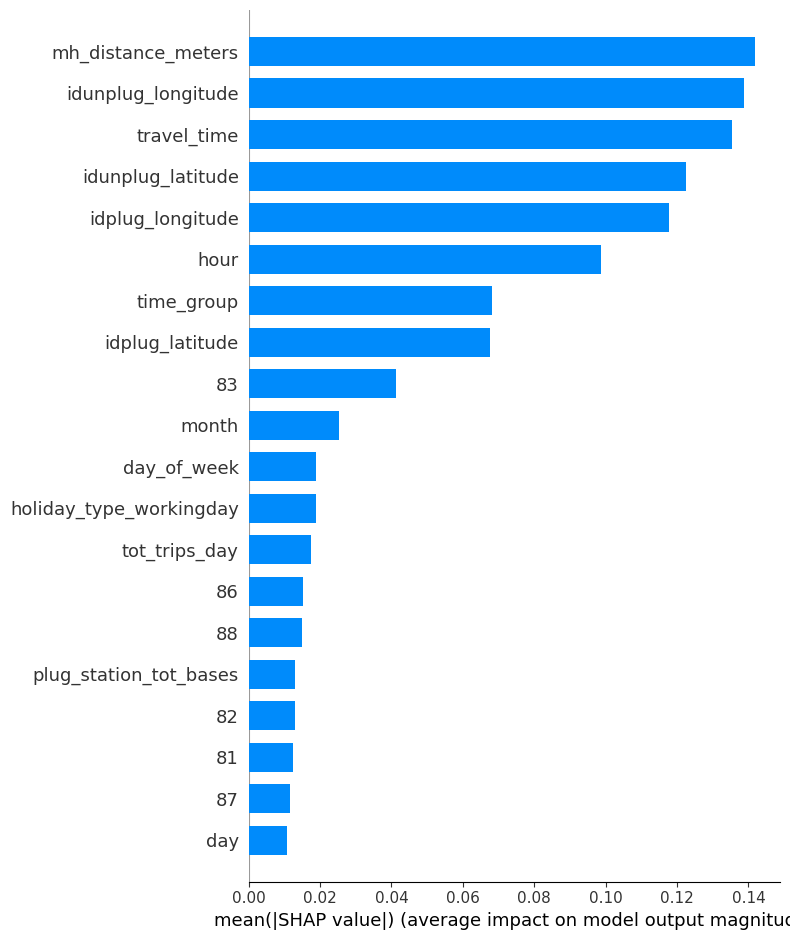

In [27]:
# Plot Shap Values Feature importance
shap.summary_plot(shap_val_test_kernel, feature_names=model_feature_names, plot_type='bar')

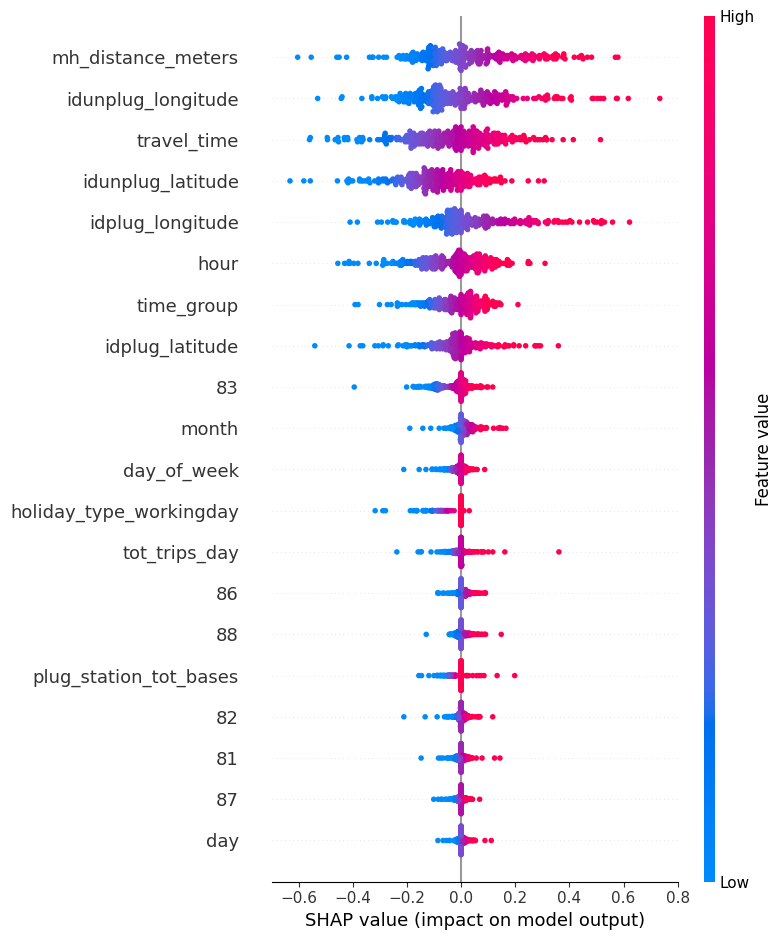

In [28]:
# Plot the aggregated SHAP values for the top ten features 
shap.summary_plot(shap_val_test_kernel,features=shap_val_test_kernel, feature_names=model_feature_names)

## Performance degradation:

In [29]:
feat_impo_test = pd.DataFrame(X_test_trans_rfc, columns=model_feature_names)
display(feat_impo_test.head())

,holiday_type_local_holiday_in_the_city_of_madrid,holiday_type_madrid_community_public_holiday,holiday_type_national_holiday,holiday_type_weekend,holiday_type_workingday,travel_time,idunplug_latitude,idunplug_longitude,unplug_station_tot_bases,idplug_latitude,idplug_longitude,plug_station_tot_bases,tot_trips_day,travel_revenue,mh_distance_meters,81,82,83,86,87,88,89,month,day,hour,time_group,day_of_week
0,0.0,0.0,0.0,0.0,1.0,0.148416,0.398492,0.754518,0.666667,0.512957,0.772087,0.666667,0.052632,0.25,0.106578,0.158491,0.000000,0.868794,0.210526,0.648649,0.685484,0.0,9.0,3.0,12.0,2.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.722068,0.244222,0.297815,0.500000,0.574514,0.057344,0.666667,0.052632,0.25,0.439799,0.316981,0.368715,0.680851,0.197368,0.405405,0.946237,0.0,6.0,13.0,20.0,4.0,3.0
2,0.0,0.0,0.0,0.0,1.0,0.561979,0.574514,0.057344,0.666667,0.408725,0.040578,0.833333,0.000000,0.25,0.148313,0.047170,0.620112,0.453901,0.776316,0.621622,0.333333,0.0,10.0,29.0,13.0,2.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.315731,0.225617,0.452899,0.666667,0.432411,0.436571,0.666667,0.052632,0.25,0.181746,0.230189,0.625698,0.960993,0.039474,0.540541,0.887097,0.0,8.0,3.0,18.0,3.0,5.0
4,0.0,0.0,0.0,0.0,1.0,0.617009,0.527184,0.366098,0.666667,0.006227,0.397397,0.833333,0.052632,0.25,0.450985,0.513208,0.620112,0.652482,0.078947,0.486486,0.991935,0.0,6.0,14.0,14.0,2.0,4.0


### Calculate SHAP Feature Importance 

In [30]:
# Calculate mean values from shap_values to extract most important feature list
vals_shap = np.abs(shap_val_test_kernel).mean(0)
vals_shap

# Store shap feature importance values in dataframe
feature_importance = pd.DataFrame(list(zip(model_feature_names, vals_shap)), columns=['col_name', 'feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

In [31]:
# List Feature importance order desc
rows_list_full = []
for index, row in feature_importance.iterrows():
    rows_list_full.append(row['col_name'])
rows_list_full

['mh_distance_meters',
 'idunplug_longitude',
 'travel_time',
 'idunplug_latitude',
 'idplug_longitude',
 'hour',
 'time_group',
 'idplug_latitude',
 '83',
 'month',
 'day_of_week',
 'holiday_type_workingday',
 'tot_trips_day',
 '86',
 '88',
 'plug_station_tot_bases',
 '82',
 '81',
 '87',
 'day',
 'unplug_station_tot_bases',
 '89',
 'holiday_type_weekend',
 'travel_revenue',
 'holiday_type_local_holiday_in_the_city_of_madrid',
 'holiday_type_madrid_community_public_holiday',
 'holiday_type_national_holiday']

In [32]:
# Model performance degradation:
# Create a copy of the test data to modify
test_asdf = feat_impo_test.copy(deep=True)

# Store original F1 score with unmodified data
original_pred = tune_rfc.predict(test_asdf)
original_f1 = f1_score(y_test, tune_rfc_pred, average='macro')

# Initialize a list to store F1 scores after each feature modification
f1_scores_rfc = [original_f1]

In [ ]:
f1_scores_rfc = [original_f1]

In [33]:
perf_deg_tune_rfc = feat_impo_test.copy(deep=True)

# Review Feature Importance and select top 10 taking into account ohe, pairwise feat, numerical and categorical
top_feat_imp_tune_rfc = ['mh_distance_meters',
 'idunplug_longitude',
 'travel_time',
 'idplug_longitude',
 'hour',
 'time_group',
 '83',
 'month',
 'day_of_week',
 'holiday_type_workingday']


# [1] Feature Importance marginalized
mh_mean = perf_deg_tune_rfc['mh_distance_meters'].mean()
perf_deg_tune_rfc['mh_distance_meters'] = mh_mean

# Store Feature [1] marginalized F1 score with unmodified data
mh_pred = tune_rfc.predict(perf_deg_tune_rfc)
mh_pred_f1 = f1_score(y_test, mh_pred, average='macro')
f1_scores_rfc.append(mh_pred_f1)

# [1, 2] Feature Importance marginalized
mode_value_lat = perf_deg_tune_rfc['idunplug_latitude'].mode()[0]  # Calculate mode
perf_deg_tune_rfc['idunplug_latitude'] = mode_value_lat

mode_value_lon = perf_deg_tune_rfc['idunplug_longitude'].mode()[0]  # Calculate mode
perf_deg_tune_rfc['idunplug_longitude'] = mode_value_lon

# Store Feature [1, 2] marginalized F1 score with unmodified data
idunplug_pred = tune_rfc.predict(perf_deg_tune_rfc)
idunplug_pred_f1 = f1_score(y_test, idunplug_pred, average='macro')
f1_scores_rfc.append(idunplug_pred_f1)

# [1, 2, 3] Feature Importance marginalized
trav_time_mean = perf_deg_tune_rfc['travel_time'].mean()
perf_deg_tune_rfc['travel_time'] = trav_time_mean

# Store Feature [1, 2, 3] marginalized F1 score with unmodified data
trav_time_pred = tune_rfc.predict(perf_deg_tune_rfc)
trav_time_f1 = f1_score(y_test, trav_time_pred, average='macro')
f1_scores_rfc.append(trav_time_f1)

# [1,2,3,4] Feature Importance marginalized
mode_value_lat = perf_deg_tune_rfc['idplug_latitude'].mode()[0]  # Calculate mode
perf_deg_tune_rfc['idplug_latitude'] = mode_value_lat

mode_value_lon = perf_deg_tune_rfc['idplug_longitude'].mode()[0]  # Calculate mode
perf_deg_tune_rfc['idplug_longitude'] = mode_value_lon

# Store Feature [1,2,3,4] marginalized F1 score with unmodified data
idplug_pred = tune_rfc.predict(perf_deg_tune_rfc)
idplug_pred_f1 = f1_score(y_test, idplug_pred, average='macro')
f1_scores_rfc.append(idplug_pred_f1)

# Store Feature [1,2,3,4,5] marginalized F1 score with unmodified data
mode_value_hour = perf_deg_tune_rfc['hour'].mode()[0]  # Calculate mode
perf_deg_tune_rfc['hour'] = mode_value_hour

# Store Feature [1,2,3,4,5] marginalized F1 score with unmodified data
hour_pred = tune_rfc.predict(perf_deg_tune_rfc)
hour_pred_f1 = f1_score(y_test, hour_pred, average='macro')
f1_scores_rfc.append(hour_pred_f1)


# [1,2,3,4,5,6] Feature Importance marginalized
mode_value_time_group = perf_deg_tune_rfc['time_group'].mode()[0]  # Calculate mode
perf_deg_tune_rfc['time_group'] = mode_value_time_group

# Store Feature [1,2,3,4,5,6] marginalized F1 score with unmodified data
time_group_pred = tune_rfc.predict(perf_deg_tune_rfc)
time_group_pred_f1 = f1_score(y_test, time_group_pred, average='macro')
f1_scores_rfc.append(time_group_pred_f1)


# Store Feature [1,2,3,4,5,6,7] marginalized F1 score with unmodified data
mean_83 = perf_deg_tune_rfc['83'].mean()
perf_deg_tune_rfc['83'] = mean_83

# Store Feature [1,2,3,4,5,6,7] marginalized F1 score with unmodified data
pred_83 = tune_rfc.predict(perf_deg_tune_rfc)
f1_83 = f1_score(y_test, pred_83, average='macro')
f1_scores_rfc.append(f1_83)


# Store Feature [1,2,3,4,5,6,7,8] marginalized F1 score with unmodified data
mode_value_month = perf_deg_tune_rfc['month'].mode()[0]  # Calculate mode
perf_deg_tune_rfc['month'] = mode_value_month

# Store Feature [1,2,3,4,5,6,7,8] marginalized F1 score with unmodified data
month_pred = tune_rfc.predict(perf_deg_tune_rfc)
month_pred_f1 = f1_score(y_test, month_pred, average='macro')
f1_scores_rfc.append(month_pred_f1)


# Store Feature [1,2,3,4,5,6,7,8,9] marginalized F1 score with unmodified data
mode_value_day_of_week = perf_deg_tune_rfc['day_of_week'].mode()[0]  # Calculate mode
perf_deg_tune_rfc['day_of_week'] = mode_value_day_of_week

# Store Feature [1,2,3,4,5,6,7,8,9] marginalized F1 score with unmodified data
day_of_week_pred = tune_rfc.predict(perf_deg_tune_rfc)
day_of_week_pred_f1 = f1_score(y_test, day_of_week_pred, average='macro')
f1_scores_rfc.append(day_of_week_pred_f1)

# [1,2,3,4,5,6,7,8,9,10] Feature Importance marginalized
# Feature performance holiday_type_ohe mode calculation
holiday_onehot = ['holiday_type_local_holiday_in_the_city_of_madrid',
 'holiday_type_madrid_community_public_holiday',
 'holiday_type_national_holiday',
 'holiday_type_weekend',
 'holiday_type_workingday']
       
# Select OneHotEncoded features to calculate mode
holiday_onehot_mode = feat_impo_test[holiday_onehot]

# Calculate the mode (most frequent combination of ohe feature holiday_type)
mode_df = holiday_onehot_mode.sum().idxmax()

# Replace values from the column with the same name as mode_df to 1.0 and the remaining columns to 0.0
df_ohe = holiday_onehot_mode.apply(lambda x: x.apply(lambda y: 1.0 if x.name == mode_df else 0.0))


perf_deg_tune_rfc['holiday_type_local_holiday_in_the_city_of_madrid'] = df_ohe['holiday_type_local_holiday_in_the_city_of_madrid']
perf_deg_tune_rfc['holiday_type_madrid_community_public_holiday'] = df_ohe['holiday_type_madrid_community_public_holiday']
perf_deg_tune_rfc['holiday_type_national_holiday'] = df_ohe['holiday_type_national_holiday']
perf_deg_tune_rfc['holiday_type_weekend'] = df_ohe['holiday_type_weekend']
perf_deg_tune_rfc['holiday_type_workingday'] = df_ohe['holiday_type_workingday']

# Store Feature [1,2,3,4,5,6,7,8,9,10] marginalized F1 score with unmodified data
pred_holiday_type = tune_rfc.predict(perf_deg_tune_rfc)
f1_holiday_type = f1_score(y_test, pred_holiday_type, average='macro')
f1_scores_rfc.append(f1_holiday_type)

In [34]:
f1_scores_rfc

[0.6098071179505121,
 0.49663072263417646,
 0.2815092193747365,
 0.26865072405843504,
 0.2324944689239238,
 0.2315632879561904,
 0.2315632879561904,
 0.2315632879561904,
 0.2315632879561904,
 0.2315632879561904,
 0.2315632879561904]

In [35]:
perf_deg_tune_rfc.head()

,holiday_type_local_holiday_in_the_city_of_madrid,holiday_type_madrid_community_public_holiday,holiday_type_national_holiday,holiday_type_weekend,holiday_type_workingday,travel_time,idunplug_latitude,idunplug_longitude,unplug_station_tot_bases,idplug_latitude,idplug_longitude,plug_station_tot_bases,tot_trips_day,travel_revenue,mh_distance_meters,81,82,83,86,87,88,89,month,day,hour,time_group,day_of_week
0,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.666667,0.574196,0.333952,0.666667,0.052632,0.25,0.269556,0.158491,0.000000,0.510465,0.210526,0.648649,0.685484,0.0,6.0,3.0,18.0,2.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.500000,0.574196,0.333952,0.666667,0.052632,0.25,0.269556,0.316981,0.368715,0.510465,0.197368,0.405405,0.946237,0.0,6.0,13.0,18.0,2.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.666667,0.574196,0.333952,0.833333,0.000000,0.25,0.269556,0.047170,0.620112,0.510465,0.776316,0.621622,0.333333,0.0,6.0,29.0,18.0,2.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.666667,0.574196,0.333952,0.666667,0.052632,0.25,0.269556,0.230189,0.625698,0.510465,0.039474,0.540541,0.887097,0.0,6.0,3.0,18.0,2.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.666667,0.574196,0.333952,0.833333,0.052632,0.25,0.269556,0.513208,0.620112,0.510465,0.078947,0.486486,0.991935,0.0,6.0,14.0,18.0,2.0,1.0


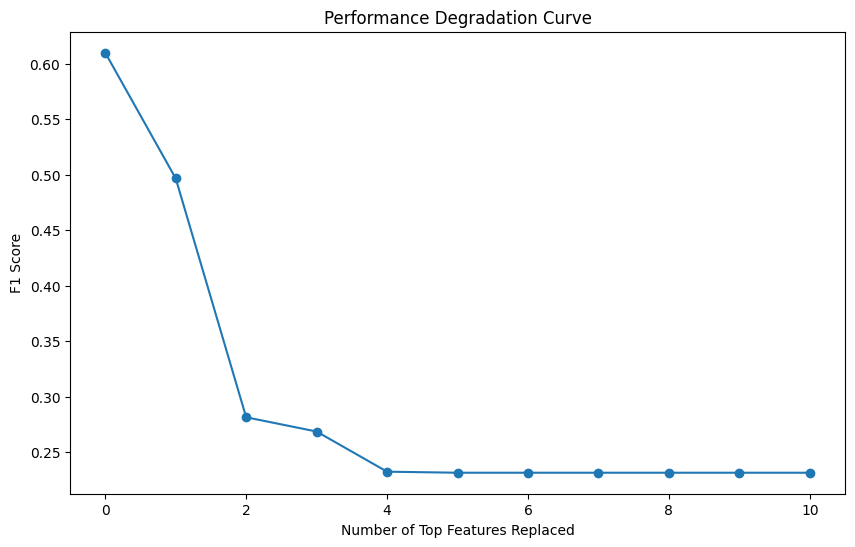

In [36]:
# Plot the performance degradation curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores_rfc)), f1_scores_rfc, marker='o')
plt.title('Performance Degradation Curve')
plt.xlabel('Number of Top Features Replaced')
plt.ylabel('F1 Score')
plt.grid(False)


Performance Degradation After Top 4 - Tune RFC f1 macro score: 0.2315632879561904

Performance Degradation After Top 4 - Tune RFC precision macro score: 0.1774009728005934

Performance Degradation After Top 4 - Tune RFC recall macro score: 0.3333333333333333

Performance Degradation After Top 4 - Tune RFC balanced accuracy score: 0.3333333333333333

Performance Degradation After Top 4 - Tune RFC accuracy score: 0.5322029184017801

Performance Degradation After Top 4 - Tune RFC cohen kappa score: 0.0

Classification Report:

              precision    recall  f1-score   support

           3       0.00      0.00      0.00     36280
           4       0.53      1.00      0.69    202822
           5       0.00      0.00      0.00    141997

    accuracy                           0.53    381099
   macro avg       0.18      0.33      0.23    381099
weighted avg       0.28      0.53      0.37    381099




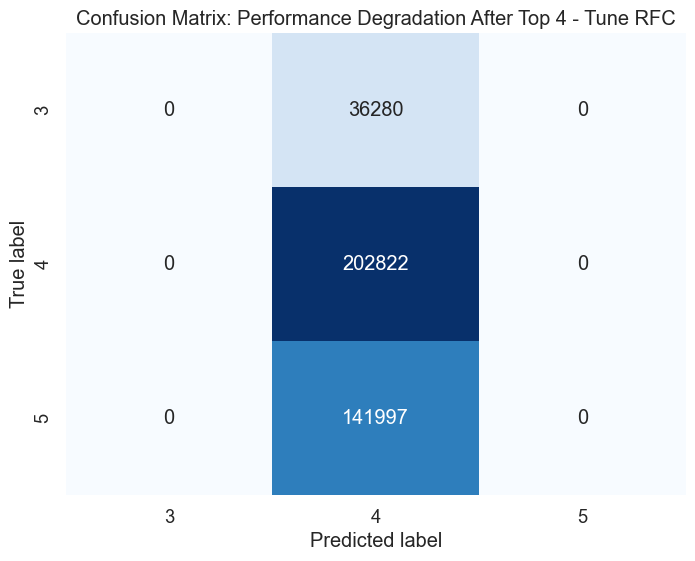

In [37]:
# Model Performance degradation error analysis after top 4 features removed ()
conf_matrix_classif_report('Performance Degradation After Top 4 - Tune RFC', y_test, hour_pred)

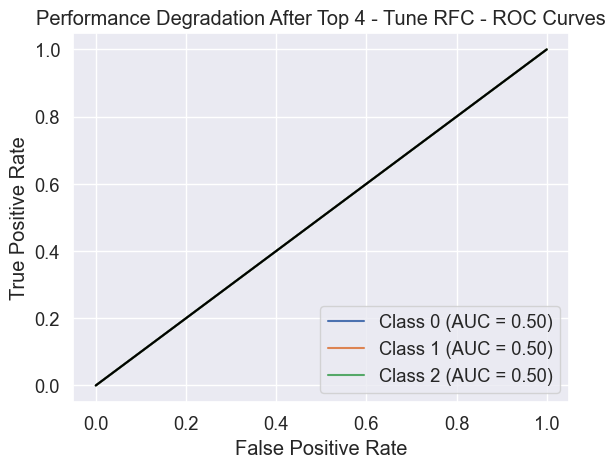

In [40]:
# Model Performance degradation error analysis after top 10 features
roc_curves("Performance Degradation After Top 4 - Tune RFC", y_train, y_test, hour_pred)

## Model RFC Optimization Optuna

In [16]:
# !NOTE Need to run first the subset X_train step with the changes on onehotenc.
numb_split = 5
rand_state = 123

# Create StratifiedKFold object for stratified cross-validation
skf = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state)

def objective_rfc(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 700, step=50)
    max_features = trial.suggest_categorical("max_features", ['sqrt','log2'])
    max_depth = trial.suggest_int("max_depth", 30, 60, step=2)
    # bootstrap = trial.suggest_categorical("bootstrap", [False, True])
    # min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 15, step = 2)
    # min_samples_split = trial.suggest_int("min_samples_split", 2, 15, step = 2)
    
  
    rfc_params = dict(n_estimators = n_estimators, max_features = max_features, max_depth = max_depth, 
                    #   min_samples_leaf = min_samples_leaf, 
                    #  min_samples_split = min_samples_split, bootstrap = bootstrap
                     )

    rfc_opt = RandomForestClassifier(**rfc_params, random_state=rand_state, n_jobs = -1) 
    score_rfc = cross_val_score(rfc_opt, X_train_trans_rfc, y_train, cv=skf, scoring='f1_macro') # Update X and y
    f1_macro_rfc = score_rfc.mean()    
    return float(f1_macro_rfc)

In [ ]:
study_rfc = optuna.create_study(directions=['maximize'])
study_rfc.optimize(objective_rfc, n_trials=30)

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

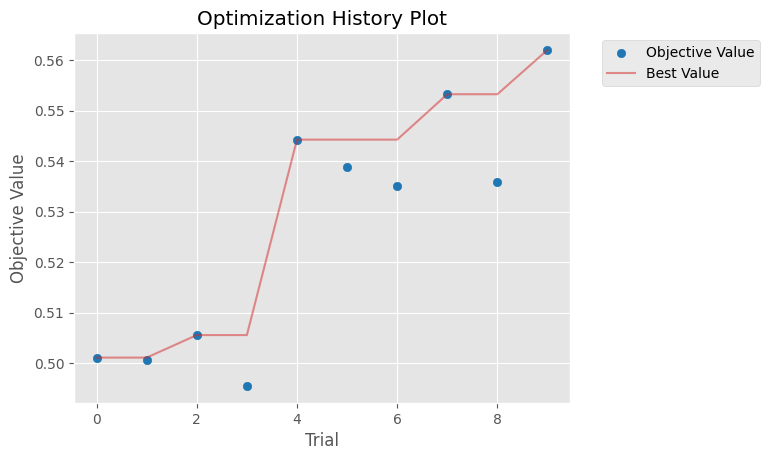

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study_rfc)

In [ ]:
rfc_params = study_rfc.best_params
print(rfc_params)

{'n_estimators': 650, 'max_features': 'log2', 'max_depth': 56, 'bootstrap': False, 'min_samples_leaf': 4, 'min_samples_split': 6}


In [ ]:
best_params_rfc = dict(n_estimators = rfc_params['n_estimators'], max_features = rfc_params['max_features'], 
                       max_depth = rfc_params['max_depth'], bootstrap = rfc_params['bootstrap'], min_samples_leaf = rfc_params['min_samples_leaf'],
                       min_samples_split = rfc_params['min_samples_split'] 
                         )

print(f"RF Classifier Optimized Hyperparameters: {best_params_rfc}")

RF Classifier Optimized Hyperparameters: {'n_estimators': 650, 'max_features': 'log2', 'max_depth': 56, 'bootstrap': False, 'min_samples_leaf': 4, 'min_samples_split': 6}


In [ ]:
#Optuna optimized RF Classifier model: 
opt_mod_rfc = RandomForestClassifier(**best_params_rfc, random_state=rand_state, n_jobs = -1)     

# Fit model with entire training dataset
opt_mod_rfc.fit(X_train_trans_rfc,y_train)

RandomForestClassifier(bootstrap=False, max_depth=56, max_features='log2',
                       min_samples_leaf=4, min_samples_split=6,
                       n_estimators=650, n_jobs=-1, random_state=123)


Tune Model - RFC with SMOTE f1 macro score: 0.5814389906303797

Tune Model - RFC with SMOTE balanced accuracy score: 0.5533732647325867

Tune Model - RFC with SMOTE accuracy score: 0.708317261394021

Tune Model - RFC with SMOTE cohen kappa score: 0.44023045911808856

Classification Report:

              precision    recall  f1-score   support

           3       0.90      0.19      0.32     36280
           4       0.68      0.90      0.78    202822
           5       0.76      0.57      0.65    141997

    accuracy                           0.71    381099
   macro avg       0.78      0.55      0.58    381099
weighted avg       0.73      0.71      0.69    381099




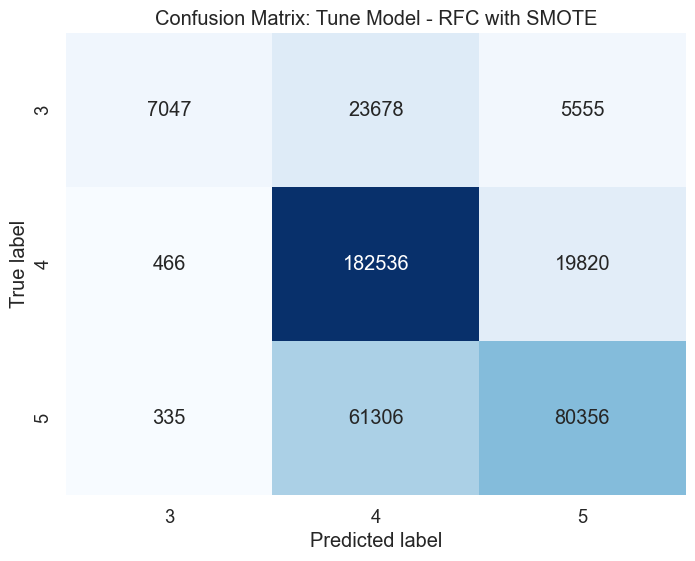

In [ ]:
# Make predictions on the test dataset
opt_mod_rfc_pred = opt_mod_rfc.predict(X_test_trans_rfc)
conf_matrix_classif_report('Tune Model - RFC with SMOTE', y_test, opt_mod_rfc_pred)

In [ ]:
test_mod = RandomForestClassifier(**best_params_rfc, random_state=rand_state, n_jobs = -1)

In [ ]:
# Make predictions on the test dataset
opt_mod_rfc_pred = opt_mod_rfc.predict(X_test_trans_rfc)

opt_mod_rfc_f1_score = f1_score(y_test, opt_mod_rfc_pred, average=None)
print(f"RFC model F1 score: {opt_mod_rfc_f1_score}")

RFC model F1 score: [0.         0.         0.66666667]


In [ ]:
print(classification_report(y_test, opt_mod_rfc_pred))
print(confusion_matrix(y_test, opt_mod_rfc_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         4
           5       0.50      1.00      0.67         5

    accuracy                           0.50        10
   macro avg       0.17      0.33      0.22        10
weighted avg       0.25      0.50      0.33        10

[[0 0 1]
 [0 0 4]
 [0 0 5]]


## Grid Tune RFC with SMOTE

In [ ]:
# Example from stackoverflow: https://stackoverflow.com/questions/50245684/using-smote-with-gridsearchcv-in-scikit-learn
# How to call parameters in Pipeline: https://stackoverflow.com/questions/58815016/cross-validating-with-imblearn-pipeline-and-gridsearchcv
numb_split = 5
rand_state = 123

# Define the scoring metric as F1 score macro
scoring = make_scorer(f1_score, average='macro')

# Start measuring time
start_time = time.time()

# Create RF classifier
rfc = RandomForestClassifier(random_state=rand_state, n_jobs=-1)

# Create StratifiedKFold object for stratified cross-validation
skf = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state)

# Create a pipeline with SMOTE and Logistic Regression
pipeline = Pipeline([
    ('smote', SMOTE(random_state=rand_state, n_jobs = -1)),
    ('rfc', rfc)
])


# Define the hyperparameters and their possible values 
param_grid_rfc = {'rfc__n_estimators': [100, 300, 450], # Based on Optuna Random Search Results.
              'rfc__max_features': ['sqrt', 'log2'], 
              'rfc__max_depth': [34,52]} # Based on Optuna Random Search Results.


# Create a grid search object
grid_search_rfc_smote = GridSearchCV(estimator=pipeline, param_grid=param_grid_rfc, scoring=scoring, cv=skf)

# Fit the grid search to your data
grid_search_rfc_smote.fit(X_train_trans_rfc, y_train)

# Calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Print the best hyperparameters
print(f"Elapsed time: {elapsed_time} seconds")
print("Best Hyperparameters:", grid_search_rfc_smote.best_params_)
print("Best performance:", grid_search_rfc_smote.best_score_)

In [20]:
std_rfc_smote_best_score = grid_search_rfc_smote.cv_results_['std_test_score'][grid_search_rfc_smote.best_index_]

print(f"RF Classifier with SMOTE GridSearch standard deviation: {std_rfc_smote_best_score}")

RF Classifier with SMOTE GridSearch standard deviation: 0.0014189050729409257


In [21]:
df_grid_rfc_smote = pd.DataFrame(grid_search_rfc_smote.cv_results_["params"])
df_grid_rfc_smote

,rfc__max_depth,rfc__max_features,rfc__n_estimators
0,34,sqrt,100
1,34,sqrt,300
2,34,sqrt,450
3,34,log2,100
4,34,log2,300
5,34,log2,450
6,52,sqrt,100
7,52,sqrt,300
8,52,sqrt,450
9,52,log2,100


In [22]:
df_grid_rfc_smote['mean_f1_macro'] = np.round(grid_search_rfc_smote.cv_results_["mean_test_score"],3)
df_grid_rfc_smote['std_f1_macro'] = np.round(grid_search_rfc_smote.cv_results_["std_test_score"],4)
df_grid_rfc_smote

,rfc__max_depth,rfc__max_features,rfc__n_estimators,mean_f1_macro,std_f1_macro
0,34,sqrt,100,0.576,0.0014
1,34,sqrt,300,0.579,0.0013
2,34,sqrt,450,0.580,0.0011
3,34,log2,100,0.564,0.0010
4,34,log2,300,0.568,0.0011
5,34,log2,450,0.569,0.0015
6,52,sqrt,100,0.582,0.0020
7,52,sqrt,300,0.585,0.0015
8,52,sqrt,450,0.586,0.0014
9,52,log2,100,0.569,0.0007


In [23]:
def plot_tuning_results_rfc_smote(df_val):
    
    df_sqrt = df_val[:][df_val.rfc__max_features == 'sqrt'].sort_values(by=['rfc__n_estimators', 'rfc__max_depth'])
    df_log2 = df_val[:][df_val.rfc__max_features == 'log2'].sort_values(by=['rfc__n_estimators', 'rfc__max_depth'])

    pivot1 = df_sqrt.pivot_table(index='rfc__max_depth',columns='rfc__n_estimators',values='mean_f1_macro')
    pivot2 = df_log2.pivot_table(index='rfc__max_depth',columns='rfc__n_estimators',values='mean_f1_macro')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    sns.heatmap(pivot1,vmin=0.10,vmax=0.65,annot=True,linewidths=0.4,ax=ax1,cmap="coolwarm_r")
    sns.heatmap(pivot2,vmin=0.10,vmax=0.65,annot=True,linewidths=0.4,ax=ax2,cmap="coolwarm_r")
    
    ax1.set_title("max_features: sqrt")
    ax2.set_title("max_features: log2")
    


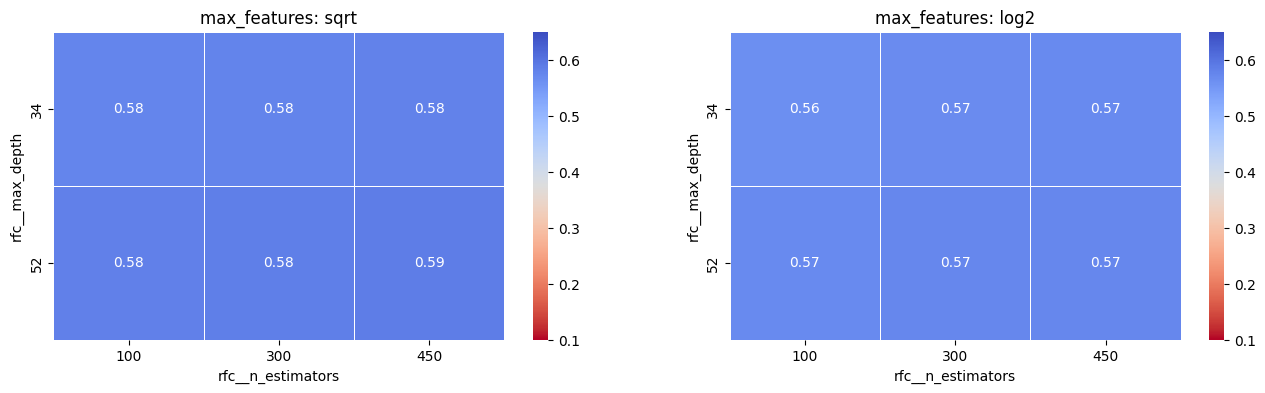

In [24]:
plot_tuning_results_rfc_smote(df_grid_rfc_smote)

In [25]:
# Store best Hyperparameters in a variable
best_param_grid_rfc_smote = grid_search_rfc_smote.best_params_

# Select best hyperparameters for optimized model training
best_grid_params_rfc_smote = dict(n_estimators = best_param_grid_rfc_smote['rfc__n_estimators'], max_features = best_param_grid_rfc_smote['rfc__max_features'], max_depth = best_param_grid_rfc_smote['rfc__max_depth']
                         )

print(f"RF Classifier with SMOTE GridSearch Optimized Hyperparameters: {best_grid_params_rfc_smote}")

RF Classifier with SMOTE GridSearch Optimized Hyperparameters: {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 52}


### Tune RFC with SMOTE model cv:

In [19]:
# Define the scoring metric as F1 score macro
scoring = make_scorer(f1_score, average='macro')

# Start measuring time
start_time = time.time()

# Create RF classifier
tune_rfc_smote_cv = RandomForestClassifier(**best_grid_params_rfc_smote,random_state=rand_state, n_jobs=-1)

# Create StratifiedKFold object for stratified cross-validation
skf = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state)

# Create a pipeline with SMOTE and Logistic Regression
pipeline_rfc_smote = Pipeline([
    ('smote', SMOTE(random_state=rand_state, n_jobs = -1)),
    ('tune_rfc_smote', tune_rfc_smote_cv)
])

# Tune RFC with SMOTE cross validation:
tune_rfc_smote_cv_results = cross_validate(pipeline_rfc_smote, X_train_trans_rfc, y_train, scoring=scoring, cv=skf, return_train_score=True)

# Calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

In [20]:
# Print the cross-validation training time:
print(f"Tune RFC with SMOTE cv time: {elapsed_time} seconds for K-fold: {numb_split}")

Tune RFC with SMOTE cv time: 7984.515733003616 seconds for K-fold: 5


In [21]:
# Train performance
print(f"Tune RFC with SMOTE Cross-val Mean f1 macro train_score: {np.mean(tune_rfc_smote_cv_results['train_score'])}")
print(f"Tune RFC with SMOTE Cross-val Standard Deviation of f1 macro train_score: {np.std(tune_rfc_smote_cv_results['train_score'])}\n")

Tune RFC with SMOTE Cross-val Mean f1 macro train_score: 0.9999633533277983
Tune RFC with SMOTE Cross-val Standard Deviation of f1 macro train_score: 2.4221491873414605e-06



In [22]:
# Validation performance
print(f"Tune RFC Cross-val Mean f1 macro val_score: {np.mean(tune_rfc_smote_cv_results['test_score'])}")
print(f"Tune RFC Cross-val Standard Deviation of f1 macro val_score: {np.std(tune_rfc_smote_cv_results['test_score'])}")

Tune RFC Cross-val Mean f1 macro val_score: 0.5864496665995181
Tune RFC Cross-val Standard Deviation of f1 macro val_score: 0.0014189050729409257


### Tune RFC with SMOTE Test performance:

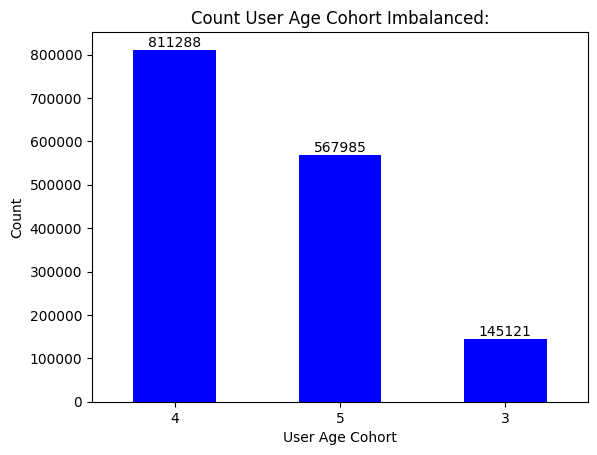

In [23]:
""" User ageRange values active population: {3:[19:26]; 4:[27:40]; 5:[41:65]}"""

# Support dataframe to plot imbalanced age cohort value counts
y_train_df = pd.DataFrame(y_train)

# User Age Cohort value counts
user_age_count = y_train_df[0].value_counts()

# Create barplot
ax = user_age_count.plot(kind='bar', rot=0, color=['blue'])

# Add values on top of each bar
for i, v in enumerate(user_age_count):
    ax.text(i, v + 1, v, ha='center', va='bottom', color='black')

plt.xlabel('User Age Cohort')
plt.ylabel('Count')
plt.title('Count User Age Cohort Imbalanced:')

# Show the plot
plt.show()

In [32]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=123, n_jobs = -1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_trans_rfc, y_train) 

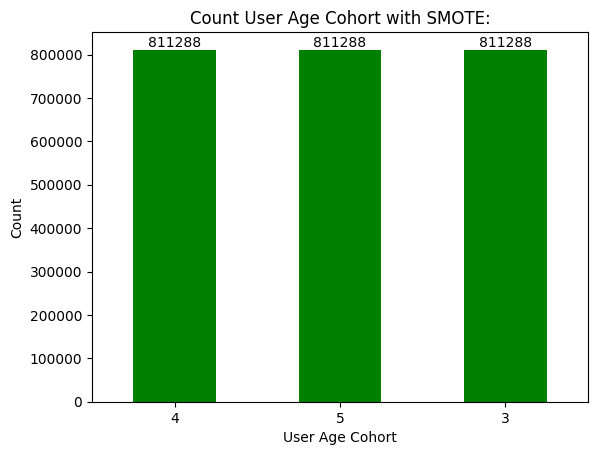

In [25]:
""" User ageRange values active population: {3:[19:26]; 4:[27:40]; 5:[41:65]}"""

# Support dataframe to plot age cohort value counts with SMOTE
y_train_resampled_df = pd.DataFrame(y_train_resampled)

# User Age Cohort value counts
user_age_count_resampled = y_train_resampled_df[0].value_counts()

# Create barplot
ax = user_age_count_resampled.plot(kind='bar', rot=0, color=['green'])

# Add values on top of each bar
for i, v in enumerate(user_age_count_resampled):
    ax.text(i, v + 1, v, ha='center', va='bottom', color='black')

plt.xlabel('User Age Cohort')
plt.ylabel('Count')
plt.title('Count User Age Cohort with SMOTE:')

# Show the plot
plt.show()

In [19]:
best_grid_params_rfc_smote = {'n_estimators': 450, 'max_features': 'sqrt', 'max_depth': 52}

rand_state = 123
# Tune RFC with SMOTE:
tune_rfc_smote = RandomForestClassifier(**best_grid_params_rfc_smote,random_state=rand_state, n_jobs=-1)
tune_rfc_smote.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=52, n_estimators=450, n_jobs=-1,
                       random_state=123)

In [20]:
# Make predictions on the test dataset
tune_rfc_smote_pred = tune_rfc_smote.predict(X_test_trans_rfc)

tune_rfc_smote_f1_score = f1_score(y_test, tune_rfc_smote_pred, average=None)
print(f"Grid Hyperparameter tunning RFC with SMOTE model F1 score: {tune_rfc_smote_f1_score}")

Grid Hyperparameter tunning RFC with SMOTE model F1 score: [0.39681828 0.76642522 0.64959438]



Tune Model - RFC with SMOTE f1 macro score: 0.6042792920109753

Tune Model - RFC with SMOTE precision macro score: 0.696949144907235

Tune Model - RFC with SMOTE recall macro score: 0.5756691504807948

Tune Model - RFC with SMOTE balanced accuracy score: 0.5756691504807948

Tune Model - RFC with SMOTE accuracy score: 0.7017599101545793

Tune Model - RFC with SMOTE cohen kappa score: 0.44177537517602405

Classification Report:

              precision    recall  f1-score   support

           3       0.68      0.28      0.40     36280
           4       0.70      0.85      0.77    202822
           5       0.72      0.59      0.65    141997

    accuracy                           0.70    381099
   macro avg       0.70      0.58      0.60    381099
weighted avg       0.70      0.70      0.69    381099




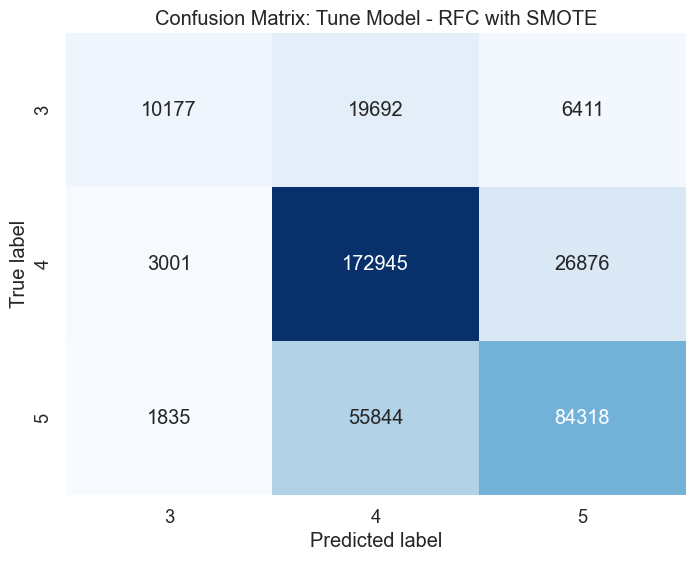

In [42]:
conf_matrix_classif_report('Tune Model - RFC with SMOTE', y_test, tune_rfc_smote_pred)

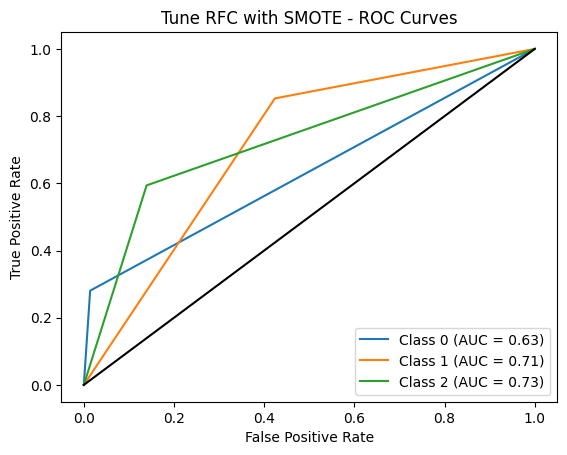

In [22]:
# Test performance
roc_curves("Tune RFC with SMOTE", y_train_resampled, y_test, tune_rfc_smote_pred)

#### Test to store tune rfc Smote model

In [ ]:
# Save rfc with smote model
joblib.dump(tune_rfc_smote, "save_file.pkl")

In [ ]:
# Load rfc with smote model
tune_rfc_smote_load = joblib.load("save_file.pkl")

In [29]:
# Extract smote test transformed
np.savetxt("F:/X_train_resampled.csv", X_train_resampled, delimiter=";")
np.savetxt("F:/y_train_resampled.csv", X_train_resampled, delimiter=";")

### SHAP Tune RFC with SMOTE

In [21]:
# Select stratified sample size
sub_X_train_bad, sub_X_test, sub_y_train_bad, sub_y_test = train_test_split(X_test_trans_rfc, y_test, test_size = 0.0008, stratify=y_test, random_state = rand_state)

In [22]:
# Summarize data using k-means due to computational limitations
summary_test_background = shap.kmeans(sub_X_test, 3)

# Create an explainer using SHAP Kernel with summarize sub_test data
kernel_explainer = shap.KernelExplainer(tune_rfc_smote.predict,summary_test_background)

# Compute SHAP valuse for the test data:
shap_val_test_kernel = kernel_explainer.shap_values(sub_X_test)

100%|██████████| 305/305 [02:27<00:00,  2.07it/s]


In [23]:
# Display random selected samples:
y_shap_sub_test = pd.DataFrame(sub_y_test)
y_shap_sub_test.value_counts() 

0
4    162
5    114
3     29
Name: count, dtype: int64

In [24]:
y_shap_sub_test[0]==3

0      False
1       True
2      False
3      False
4      False
       ...  
495    False
496    False
497    False
498     True
499    False
Name: 0, Length: 500, dtype: bool

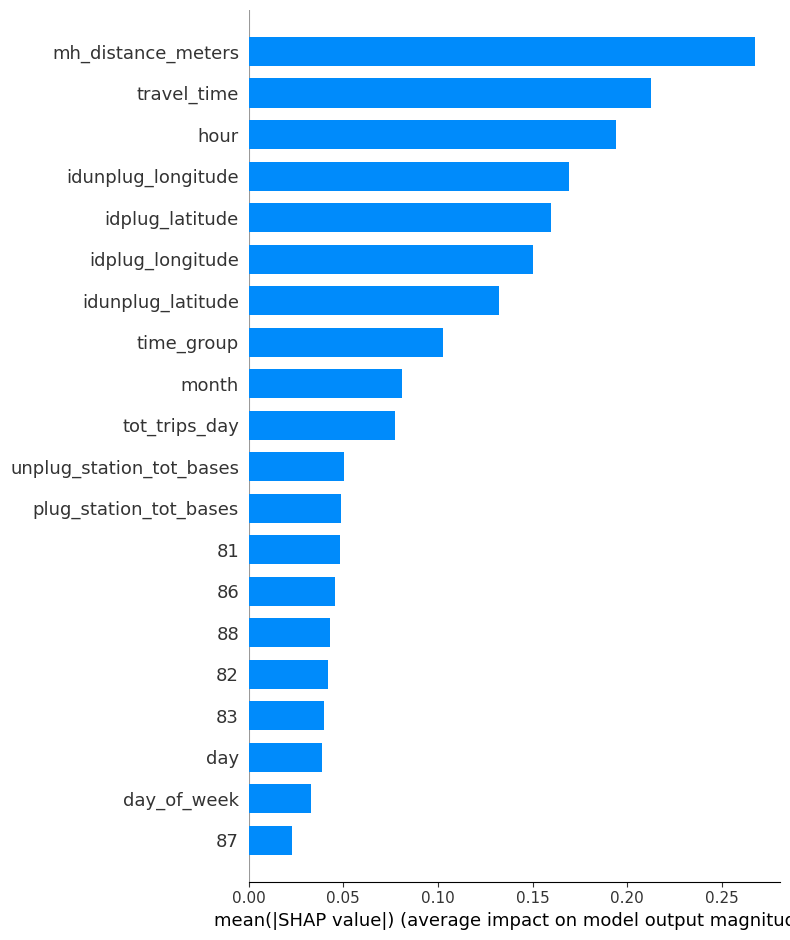

In [24]:
# Plot Shap Values Feature importance
shap.summary_plot(shap_val_test_kernel, feature_names=model_feature_names, plot_type='bar')

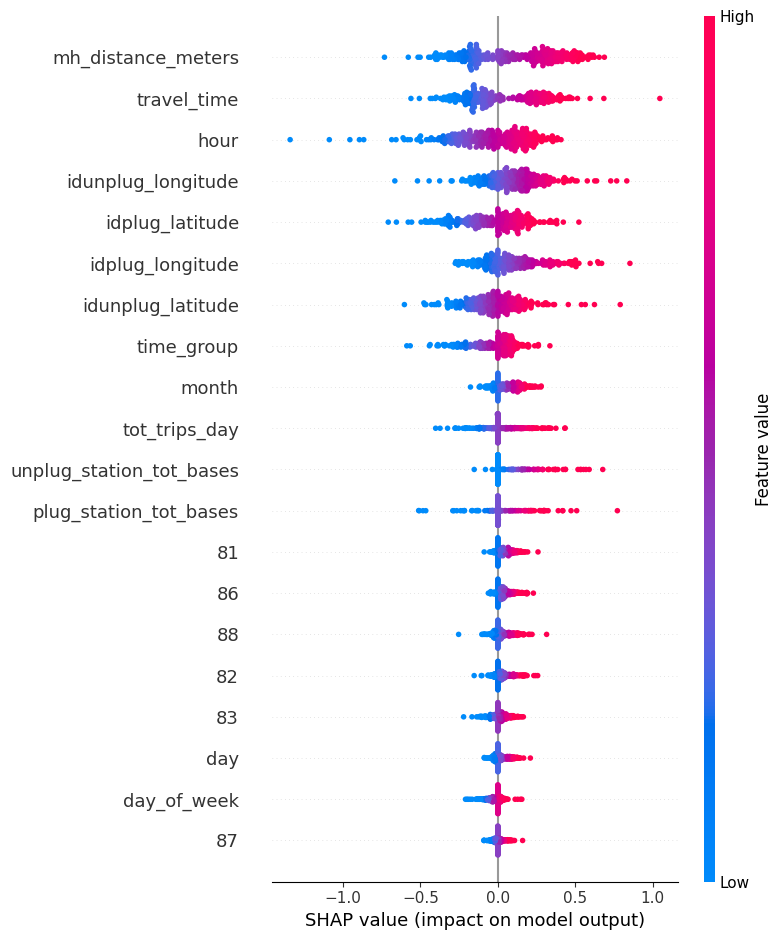

In [25]:
# Plot the aggregated SHAP values for the top ten features 
shap.summary_plot(shap_val_test_kernel,features=shap_val_test_kernel, feature_names=model_feature_names)

## Performance degradation:

In [29]:
feat_impo_test = pd.DataFrame(X_test_trans_rfc, columns=model_feature_names)
display(feat_impo_test.head())

,holiday_type_local_holiday_in_the_city_of_madrid,holiday_type_madrid_community_public_holiday,holiday_type_national_holiday,holiday_type_weekend,holiday_type_workingday,travel_time,idunplug_latitude,idunplug_longitude,unplug_station_tot_bases,idplug_latitude,idplug_longitude,plug_station_tot_bases,tot_trips_day,travel_revenue,mh_distance_meters,81,82,83,86,87,88,89,month,day,hour,time_group,day_of_week
0,0.0,0.0,0.0,0.0,1.0,0.148416,0.398492,0.754518,0.666667,0.512957,0.772087,0.666667,0.052632,0.25,0.106578,0.158491,0.000000,0.868794,0.210526,0.648649,0.685484,0.0,9.0,3.0,12.0,2.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.722068,0.244222,0.297815,0.500000,0.574514,0.057344,0.666667,0.052632,0.25,0.439799,0.316981,0.368715,0.680851,0.197368,0.405405,0.946237,0.0,6.0,13.0,20.0,4.0,3.0
2,0.0,0.0,0.0,0.0,1.0,0.561979,0.574514,0.057344,0.666667,0.408725,0.040578,0.833333,0.000000,0.25,0.148313,0.047170,0.620112,0.453901,0.776316,0.621622,0.333333,0.0,10.0,29.0,13.0,2.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.315731,0.225617,0.452899,0.666667,0.432411,0.436571,0.666667,0.052632,0.25,0.181746,0.230189,0.625698,0.960993,0.039474,0.540541,0.887097,0.0,8.0,3.0,18.0,3.0,5.0
4,0.0,0.0,0.0,0.0,1.0,0.617009,0.527184,0.366098,0.666667,0.006227,0.397397,0.833333,0.052632,0.25,0.450985,0.513208,0.620112,0.652482,0.078947,0.486486,0.991935,0.0,6.0,14.0,14.0,2.0,4.0


### Calculate SHAP Feature Importance 

In [26]:
# Calculate mean values from shap_values to extract most important feature list
vals_shap = np.abs(shap_val_test_kernel).mean(0)
vals_shap

# Store shap feature importance values in dataframe
feature_importance = pd.DataFrame(list(zip(model_feature_names, vals_shap)), columns=['col_name', 'feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

In [27]:
# List Feature importance order desc
rows_list_full = []
for index, row in feature_importance.iterrows():
    rows_list_full.append(row['col_name'])
rows_list_full

['mh_distance_meters',
 'travel_time',
 'hour',
 'idunplug_longitude',
 'idplug_latitude',
 'idplug_longitude',
 'idunplug_latitude',
 'time_group',
 'month',
 'tot_trips_day',
 'unplug_station_tot_bases',
 'plug_station_tot_bases',
 '81',
 '86',
 '88',
 '82',
 '83',
 'day',
 'day_of_week',
 '87',
 '89',
 'holiday_type_workingday',
 'holiday_type_weekend',
 'travel_revenue',
 'holiday_type_national_holiday',
 'holiday_type_madrid_community_public_holiday',
 'holiday_type_local_holiday_in_the_city_of_madrid']

In [31]:
# Model performance degradation:
# Create a copy of the test data to modify
test_asdf = feat_impo_test.copy(deep=True)

# Store original F1 score with unmodified data
original_pred = tune_rfc_smote.predict(test_asdf)
original_f1 = f1_score(y_test, tune_rfc_smote_pred, average='macro')

# Initialize a list to store F1 scores after each feature modification
f1_scores_rfc = [original_f1]

In [ ]:
f1_scores_rfc = [original_f1]

In [32]:
perf_deg_tune_rfc_smote = feat_impo_test.copy(deep=True)

# Review Feature Importance and select top 10 taking into account ohe, pairwise feat, numerical and categorical
top_feat_imp_tune_rfc_smote = ['mh_distance_meters',
 'travel_time',
 'hour',
 'idunplug_longitude',
 'idplug_latitude',
 'time_group',
 'month',
 'tot_trips_day',
 'unplug_station_tot_bases',
 'plug_station_tot_bases']


# [1] Feature Importance marginalized
mh_mean = perf_deg_tune_rfc_smote['mh_distance_meters'].mean()
perf_deg_tune_rfc_smote['mh_distance_meters'] = mh_mean

# Store Feature [1] marginalized F1 score with unmodified data
mh_pred = tune_rfc_smote.predict(perf_deg_tune_rfc_smote)
mh_pred_f1 = f1_score(y_test, mh_pred, average='macro')
f1_scores_rfc.append(mh_pred_f1)

# [1, 2] Feature Importance marginalized
trav_time_mean = perf_deg_tune_rfc_smote['travel_time'].mean()
perf_deg_tune_rfc_smote['travel_time'] = trav_time_mean

# Store Feature [1, 2] marginalized F1 score with unmodified data
trav_time_pred = tune_rfc_smote.predict(perf_deg_tune_rfc_smote)
trav_time_f1 = f1_score(y_test, trav_time_pred, average='macro')
f1_scores_rfc.append(trav_time_f1)

# [1, 2, 3] Feature Importance marginalized
mode_value_hour = perf_deg_tune_rfc_smote['hour'].mode()[0]  # Calculate mode
perf_deg_tune_rfc_smote['hour'] = mode_value_hour

# Store Feature [1, 2, 3] marginalized F1 score with unmodified data
hour_pred = tune_rfc_smote.predict(perf_deg_tune_rfc_smote)
hour_pred_f1 = f1_score(y_test, hour_pred, average='macro')
f1_scores_rfc.append(hour_pred_f1)

# [1,2,3,4] Feature Importance marginalized
mode_value_lat = perf_deg_tune_rfc_smote['idunplug_latitude'].mode()[0]  # Calculate mode
perf_deg_tune_rfc_smote['idunplug_latitude'] = mode_value_lat

mode_value_lon = perf_deg_tune_rfc_smote['idunplug_longitude'].mode()[0]  # Calculate mode
perf_deg_tune_rfc_smote['idunplug_longitude'] = mode_value_lon

# Store Feature [1,2,3,4] marginalized F1 score with unmodified data
idunplug_pred = tune_rfc_smote.predict(perf_deg_tune_rfc_smote)
idunplug_pred_f1 = f1_score(y_test, idunplug_pred, average='macro')
f1_scores_rfc.append(idunplug_pred_f1)

# Store Feature [1,2,3,4,5] marginalized F1 score with unmodified data
mode_value_lat = perf_deg_tune_rfc_smote['idplug_latitude'].mode()[0]  # Calculate mode
perf_deg_tune_rfc_smote['idplug_latitude'] = mode_value_lat

mode_value_lon = perf_deg_tune_rfc_smote['idplug_longitude'].mode()[0]  # Calculate mode
perf_deg_tune_rfc_smote['idplug_longitude'] = mode_value_lon

# Store Feature [1,2,3,4,5] marginalized F1 score with unmodified data
idplug_pred = tune_rfc_smote.predict(perf_deg_tune_rfc_smote)
idplug_pred_f1 = f1_score(y_test, idplug_pred, average='macro')
f1_scores_rfc.append(idplug_pred_f1)

# [1,2,3,4,5,6] Feature Importance marginalized
mode_value_time_group = perf_deg_tune_rfc_smote['time_group'].mode()[0]  # Calculate mode
perf_deg_tune_rfc_smote['time_group'] = mode_value_time_group

# Store Feature [1,2,3,4,5,6] marginalized F1 score with unmodified data
time_group_pred = tune_rfc_smote.predict(perf_deg_tune_rfc_smote)
time_group_pred_f1 = f1_score(y_test, time_group_pred, average='macro')
f1_scores_rfc.append(time_group_pred_f1)

# Store Feature [1,2,3,4,5,6,7] marginalized F1 score with unmodified data
mode_value_month = perf_deg_tune_rfc_smote['month'].mode()[0]  # Calculate mode
perf_deg_tune_rfc_smote['month'] = mode_value_month

# Store Feature [1,2,3,4,5,6,7] marginalized F1 score with unmodified data
month_pred = tune_rfc_smote.predict(perf_deg_tune_rfc_smote)
month_pred_f1 = f1_score(y_test, month_pred, average='macro')
f1_scores_rfc.append(month_pred_f1)


# Store Feature [1,2,3,4,5,6,7,8] marginalized F1 score with unmodified data
mean_tot_trips_day = perf_deg_tune_rfc_smote['tot_trips_day'].mean()
perf_deg_tune_rfc_smote['tot_trips_day'] = mean_tot_trips_day

# Store Feature [1,2,3,4,5,6,7,8] marginalized F1 score with unmodified data
pred_tot_trips_day = tune_rfc_smote.predict(perf_deg_tune_rfc_smote)
pred_tot_trips_day_f1 = f1_score(y_test, pred_tot_trips_day, average='macro')
f1_scores_rfc.append(pred_tot_trips_day_f1)

# Store Feature [1,2,3,4,5,6,7,8,9] marginalized F1 score with unmodified data
mean_unplug_station_tot_bases = perf_deg_tune_rfc_smote['unplug_station_tot_bases'].mean()
perf_deg_tune_rfc_smote['unplug_station_tot_bases'] = mean_unplug_station_tot_bases

# Store Feature [1,2,3,4,5,6,7,8,9] marginalized F1 score with unmodified data
pred_unplug_station_tot_bases = tune_rfc_smote.predict(perf_deg_tune_rfc_smote)
pred_unplug_station_tot_bases_f1 = f1_score(y_test, pred_unplug_station_tot_bases, average='macro')
f1_scores_rfc.append(pred_unplug_station_tot_bases_f1)

# [1,2,3,4,5,6,7,8,9,10] Feature Importance marginalized
mean_plug_station_tot_bases = perf_deg_tune_rfc_smote['plug_station_tot_bases'].mean()
perf_deg_tune_rfc_smote['plug_station_tot_bases'] = mean_plug_station_tot_bases

# Store Feature [1,2,3,4,5,6,7,8,9,10] marginalized F1 score with unmodified data
pred_plug_station_tot_bases = tune_rfc_smote.predict(perf_deg_tune_rfc_smote)
pred_plug_station_tot_bases_f1 = f1_score(y_test, pred_plug_station_tot_bases, average='macro')
f1_scores_rfc.append(pred_plug_station_tot_bases_f1)

In [33]:
f1_scores_rfc

[0.6042792920109753,
 0.5408733244901444,
 0.5005963806743122,
 0.416150445256567,
 0.29790389151786484,
 0.2636758417263834,
 0.2644004769802687,
 0.2602895235318182,
 0.0627409764851856,
 0.05796895864526113,
 0.05794893050840283]

In [35]:
perf_deg_tune_rfc_smote.head()

,holiday_type_local_holiday_in_the_city_of_madrid,holiday_type_madrid_community_public_holiday,holiday_type_national_holiday,holiday_type_weekend,holiday_type_workingday,travel_time,idunplug_latitude,idunplug_longitude,unplug_station_tot_bases,idplug_latitude,idplug_longitude,plug_station_tot_bases,tot_trips_day,travel_revenue,mh_distance_meters,81,82,83,86,87,88,89,month,day,hour,time_group,day_of_week
0,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.663483,0.574196,0.333952,0.664707,0.06181,0.25,0.269556,0.158491,0.000000,0.868794,0.210526,0.648649,0.685484,0.0,6.0,3.0,18.0,2.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.663483,0.574196,0.333952,0.664707,0.06181,0.25,0.269556,0.316981,0.368715,0.680851,0.197368,0.405405,0.946237,0.0,6.0,13.0,18.0,2.0,3.0
2,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.663483,0.574196,0.333952,0.664707,0.06181,0.25,0.269556,0.047170,0.620112,0.453901,0.776316,0.621622,0.333333,0.0,6.0,29.0,18.0,2.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.388325,0.574196,0.333952,0.663483,0.574196,0.333952,0.664707,0.06181,0.25,0.269556,0.230189,0.625698,0.960993,0.039474,0.540541,0.887097,0.0,6.0,3.0,18.0,2.0,5.0
4,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.663483,0.574196,0.333952,0.664707,0.06181,0.25,0.269556,0.513208,0.620112,0.652482,0.078947,0.486486,0.991935,0.0,6.0,14.0,18.0,2.0,4.0


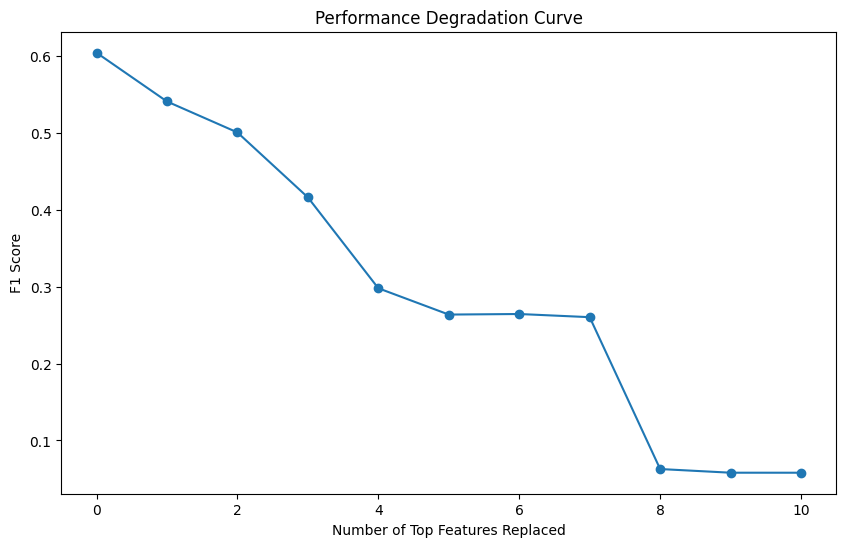

In [36]:
# Plot the performance degradation curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores_rfc)), f1_scores_rfc, marker='o')
plt.title('Performance Degradation Curve')
plt.xlabel('Number of Top Features Replaced')
plt.ylabel('F1 Score')
plt.grid(False)


Performance Degradation After Top 10 - RFC + SMOTE f1 macro score: 0.05794893050840283

Performance Degradation After Top 10 - RFC + SMOTE precision macro score: 0.03173278684366355

Performance Degradation After Top 10 - RFC + SMOTE recall macro score: 0.3333333333333333

Performance Degradation After Top 10 - RFC + SMOTE balanced accuracy score: 0.3333333333333333

Performance Degradation After Top 10 - RFC + SMOTE accuracy score: 0.09519836053099064

Performance Degradation After Top 10 - RFC + SMOTE cohen kappa score: 0.0

Classification Report:

              precision    recall  f1-score   support

           3       0.10      1.00      0.17     36280
           4       0.00      0.00      0.00    202822
           5       0.00      0.00      0.00    141997

    accuracy                           0.10    381099
   macro avg       0.03      0.33      0.06    381099
weighted avg       0.01      0.10      0.02    381099




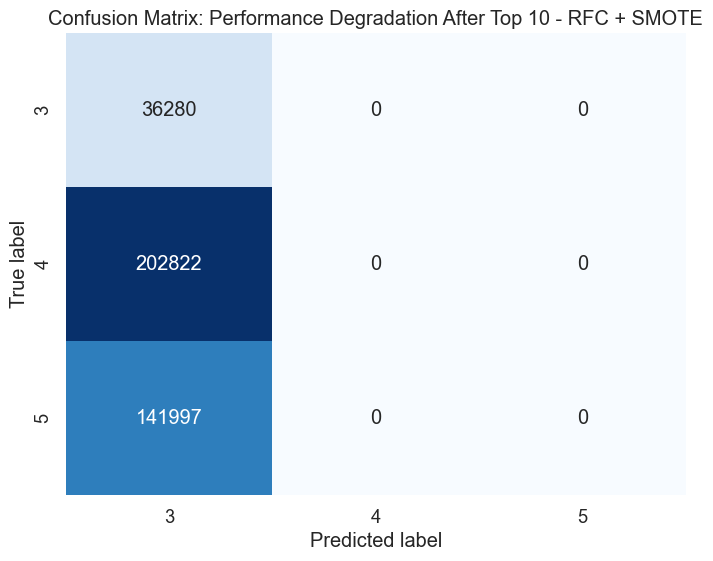

In [59]:
# Model Performance degradation error analysis after top 10 features
conf_matrix_classif_report('Performance Degradation After Top 10 - RFC + SMOTE', y_test, pred_plug_station_tot_bases)

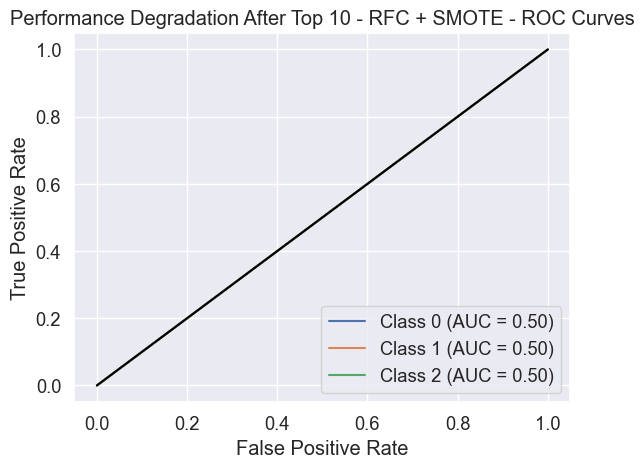

In [60]:
# Model Performance degradation error analysis after top 10 features
roc_curves("Performance Degradation After Top 10 - RFC + SMOTE", y_train_resampled, y_test, pred_plug_station_tot_bases)

In [52]:
tune_rfc_f1_deg = [0.6098071179505121,
 0.49663072263417646,
 0.2815092193747365,
 0.26865072405843504,
 0.2324944689239238,
 0.2315632879561904,
 0.2315632879561904,
 0.2315632879561904,
 0.2315632879561904,
 0.2315632879561904,
 0.2315632879561904]
 
tune_rfc_smote_f1_deg = [0.6042792920109753,
 0.5408733244901444,
 0.5005963806743122,
 0.416150445256567,
 0.29790389151786484,
 0.2636758417263834,
 0.2644004769802687,
 0.2602895235318182,
 0.0627409764851856,
 0.05796895864526113,
 0.05794893050840283]


# Create Performance degradation graph tuned RFC with(out) SMOTE
graph_perf_deg_rfc_df =  pd.DataFrame(list(zip(tune_rfc_f1_deg, tune_rfc_smote_f1_deg)),
              columns=['Tune RFC','Tune RFC + SMOTE'])

In [53]:
graph_perf_deg_rfc_df

,Tune RFC,Tune RFC + SMOTE
0,0.609807,0.604279
1,0.496631,0.540873
2,0.281509,0.500596
3,0.268651,0.416150
4,0.232494,0.297904
5,0.231563,0.263676
6,0.231563,0.264400
7,0.231563,0.260290
8,0.231563,0.062741
9,0.231563,0.057969


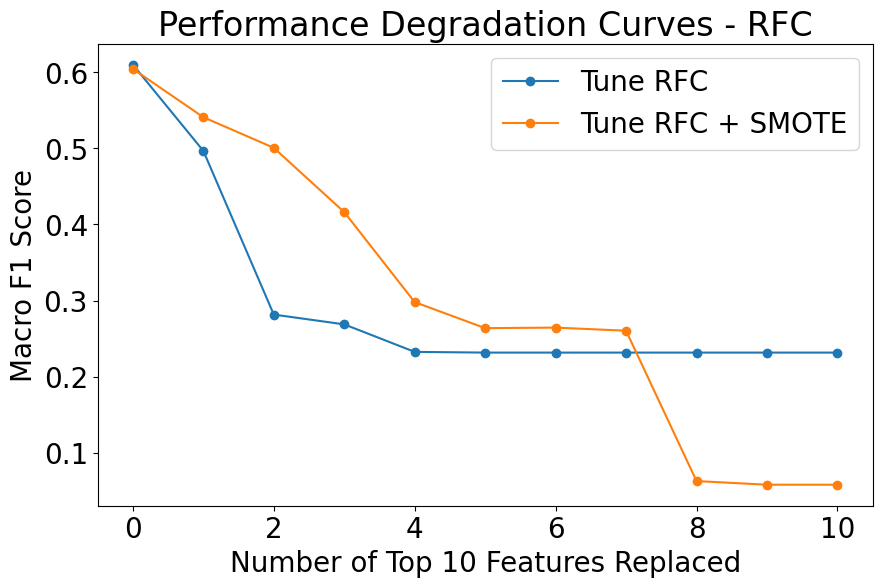

In [ ]:
# Plot the performance degradation curve
fig = plt.figure(figsize=(10, 6))
# Set font size to be further exported for the paper
plt.rcParams.update({'font.size': 20})

# Plot each performance degradation curve and graph_perf_deg_rfc_df add col_name to the legend
for column in graph_perf_deg_rfc_df.columns:
    plt.plot(range(graph_perf_deg_rfc_df.shape[0]), graph_perf_deg_rfc_df[column], marker='o', label=column)

plt.title('Performance Degradation Curves - RFC')
plt.xlabel('Number of Top 10 Features Replaced')
plt.ylabel('Macro F1 Score')
plt.grid(False)
plt.legend()
plt.savefig('performance_degra_tune_rfc.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [180]:
import numpy as np
import pandas as pd

# Manually creating dataframe to prevent from re-running predictions
graph_perf_deg_rfc = {
    'Tune RFC': [0.609807, 0.496631, 0.281509, 0.268651, 0.232494, 0.231563, 0.231563, 0.231563, 0.231563, 0.231563, 0.231563],
    'Tune RFC + SMOTE': [0.604279, 0.540873, 0.500596, 0.416150, 0.297904, 0.263676, 0.264400, 0.260290, 0.062741, 0.057969, 0.057949]
}
graph_perf_deg_rfc_df = pd.DataFrame(graph_perf_deg_rfc)

# Calculate the Performance degradation AUC using the trapezoidal rule
auc_tune_rfc = np.trapz(graph_perf_deg_rfc_df['Tune RFC'])
auc_tune_rfc_smote = np.trapz(graph_perf_deg_rfc_df['Tune RFC + SMOTE'])

print(f"Performance degradation AUC for Tune RFC: {auc_tune_rfc}")
print(f"Performance degradation AUC for Tune RFC + SMOTE: {auc_tune_rfc_smote}")

Performance degradation AUC for Tune RFC: 2.857785
Performance degradation AUC for Tune RFC + SMOTE: 2.9957130000000003


## t-SNE with SMOTE Problem complexity

In [ ]:
# SHAP Feature Importance col_names
model_feature_names = ['holiday_type_local_holiday_in_the_city_of_madrid',
 'holiday_type_madrid_community_public_holiday',
 'holiday_type_national_holiday',
 'holiday_type_weekend',
 'holiday_type_workingday',
 'travel_time',
 'idunplug_latitude',
 'idunplug_longitude',
 'unplug_station_tot_bases',
 'idplug_latitude',
 'idplug_longitude',
 'plug_station_tot_bases',
 'tot_trips_day',
 'travel_revenue',
 'mh_distance_meters',
 '81',
 '82',
 '83',
 '86',
 '87',
 '88',
 '89',
 'month',
 'day',
 'hour',
 'time_group',
 'day_of_week']

In [168]:
X_train_resampled.shape

(2433864, 27)

In [170]:
# Create representative subset dataset to be able to plot t-SNE: 0.029
bike_subset_tsne, __, bike_subset_tsne_age,__ = train_test_split(X_train_resampled,y_train_resampled, stratify=y_train_resampled,train_size=0.029, random_state=123)

In [171]:
# Filter resampled data for t-SNE plot same features as without SMOTE
cols_to_remove = {0, 1, 2,3, 4, 25, 26}
all_cols = set(range(bike_subset_tsne.shape[1]))
cols_to_keep = list(all_cols - cols_to_remove)

# Use numpy indexing to keep the columns that are not removed
filter_bike_subset_tsne = bike_subset_tsne[:, cols_to_keep]

In [172]:
filter_bike_subset_tsne.shape

(70582, 20)

In [173]:
filter_bike_subset_tsne[[0],]

array([[ 0.43023902,  0.21389018,  0.49952333,  0.83333333,  0.37658184,
         0.31796804,  0.83333333,  0.05263158,  0.25      ,  0.26015311,
         0.36037736,  0.59217877,  0.36170213,  0.96052632,  0.43243243,
         0.05913978,  0.04545455, 11.        , 26.        ,  8.        ]])

In [174]:
print(bike_subset_tsne_age.shape)
print(np.unique(bike_subset_tsne_age[:]))
filter_bike_subset_tsne.shape

(70582,)
[3 4 5]


(70582, 20)

In [175]:
rand_state = 123
tsne = TSNE(n_components=2, random_state=rand_state, learning_rate=50)

tsne_features = tsne.fit_transform(filter_bike_subset_tsne)

In [176]:
tsne_features[1:4,:]

array([[-30.224312 ,  -5.198761 ],
       [  6.5843854, -16.702606 ],
       [ 13.924424 ,  12.447202 ]], dtype=float32)

In [177]:
bike_subset_tsne_df = df = pd.DataFrame({
    'tsne_x': tsne_features[:,0],
    'tsne_y': tsne_features[:,1],
    'ageRange': bike_subset_tsne_age
})

In [178]:
bike_subset_tsne_df.head()

,tsne_x,tsne_y,ageRange
0,18.444162,19.190073,4
1,-30.224312,-5.198761,4
2,6.584385,-16.702606,4
3,13.924424,12.447202,4
4,7.135831,32.261097,3


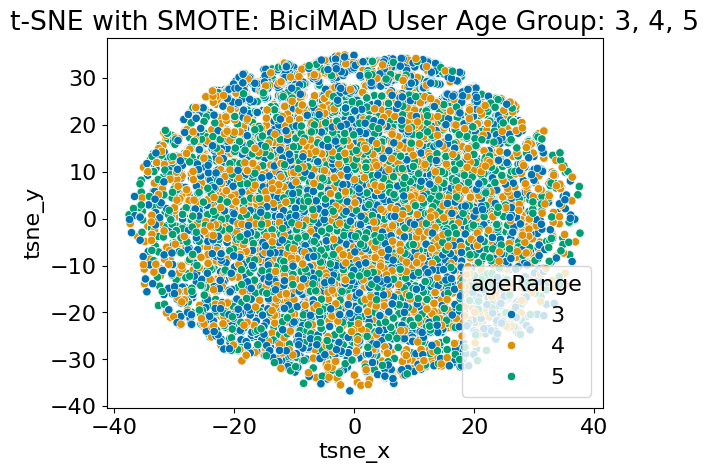

In [179]:
# Define color palette
custom_palette = sns.color_palette("colorblind")

# Set font size to be further exported for the paper
plt.rcParams.update({'font.size': 16})

sns.scatterplot(x='tsne_x',y='tsne_y',hue='ageRange',data=bike_subset_tsne_df,palette=custom_palette)
plt.title('t-SNE with SMOTE: BiciMAD User Age Group: 3, 4, 5')

plt.savefig('t-sne_age_3-4-5_smote.pdf', format='pdf', bbox_inches='tight')
plt.show()